In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import accuracy_score

import seaborn as sns
import cv2
import os
import random
import datetime
from google.colab.patches import cv2_imshow
from keras.models import Model
# from sklearn.metrics import confusion_matrix, plot_confusion_matrix  # accuracy 지표 계산

# 할당된 GPU 확인

In [ ]:
# gpu 사용할 수 있는지 확인
print(tf.__version__)
tf.config.list_physical_devices('GPU') #2.xx 부터는 gpu_available 대신 이렇게 하라고 한다

2.12.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# 뭐 사용하는지 궁금
from tensorflow.python.client import device_lib
device_lib.list_local_devices() # NVIDIA A100-SXM4-40GB

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2932890206145951732
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 40129593344
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6554200737724953915
 physical_device_desc: "device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0"
 xla_global_id: 416903419]

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# Upload Image Samples from Github
from google.colab import files
uploaded = files.upload()

Saving CNT.zip to CNT.zip


In [ ]:
!unzip -qq ./CNT.zip

replace 0.05-No/0.05-No-0001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace 0.05-No/0.05-No-0002.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace 0.05-No/0.05-No-0002.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


# Image Samples Pre-processing

## Each Model

### Pre-processing

In [ ]:
import os
print(os.getcwd())

/content


In [ ]:
CURRENT = './'
CONTENTS = ['0.05', '0.1', '0.2', '0.4']  # CNT Powder Content
CATEGORIES = ['No', 'Sonic']

In [ ]:
CNT_IMG = []
arr = []

for content in CONTENTS:
  for category in CATEGORIES:
    Path = CURRENT + content + '-' + category
    # print(Path)
    for i, file in enumerate(os.listdir(Path)):
      if file == '.ipynb_checkpoints' or i > 40:
        continue

      # Change Image to Numpy array in grayscale
      img_array = cv2.imread(os.path.join(Path, file), cv2.IMREAD_GRAYSCALE)
      # 이미지 파일에, " CNT powder content, sonication 여부" 추가
      CNT_IMG.append([img_array, CONTENTS.index(content), CATEGORIES.index(category), file])
      if content+'-'+category == '0.4-No':
        arr.append(file)

In [ ]:
len(CNT_IMG)

320

In [ ]:
arr.sort()
arr

['0.4-No-0001.jpg',
 '0.4-No-0002.jpg',
 '0.4-No-0003.jpg',
 '0.4-No-0004.jpg',
 '0.4-No-0005.jpg',
 '0.4-No-0006.jpg',
 '0.4-No-0008.jpg',
 '0.4-No-0009.jpg',
 '0.4-No-0010.jpg',
 '0.4-No-0011.jpg',
 '0.4-No-0012.jpg',
 '0.4-No-0013.jpg',
 '0.4-No-0014.jpg',
 '0.4-No-0015.jpg',
 '0.4-No-0016.jpg',
 '0.4-No-0017.jpg',
 '0.4-No-0018.jpg',
 '0.4-No-0019.jpg',
 '0.4-No-0020.jpg',
 '0.4-No-0021.jpg',
 '0.4-No-0022.jpg',
 '0.4-No-0023.jpg',
 '0.4-No-0025.jpg',
 '0.4-No-0026.jpg',
 '0.4-No-0027.jpg',
 '0.4-No-0028.jpg',
 '0.4-No-0029.jpg',
 '0.4-No-0030.jpg',
 '0.4-No-0031.jpg',
 '0.4-No-0032.jpg',
 '0.4-No-0033.jpg',
 '0.4-No-0034.jpg',
 '0.4-No-0035.jpg',
 '0.4-No-0036.jpg',
 '0.4-No-0037.jpg',
 '0.4-No-0038.jpg',
 '0.4-No-0039.jpg',
 '0.4-No-0040.jpg',
 '0.4-No-0041.jpg',
 '0.4-No-0042.jpg']

In [ ]:
# Show grey-scale Image Sample

name = CNT_IMG[120][3]    # 0.1-Sonic-0013.jpg
img_array = CNT_IMG[120][0]
plt.imshow(img_array, cmap='gray')
plt.xticks([]) # hide x-axis
plt.yticks([]) # hide y-axis
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

Error in callback <function flush_figures at 0x7fece867d480> (for post_execute):


KeyboardInterrupt: ignored

#### (a) 4 by 6 로 이미지 자르고, 자른 이미지는 256*256(pixel) 사이즈로 변환하였다.

In [ ]:
# Four splits in row and six splits in column -> 24 small samples from one 1080 x 1920 image
n_row = 4
n_col = 6

# Resize image to 256 x 256 pixels
img_size = 256

SMALL_IMG = []

for img_array, content, label, name in CNT_IMG:
    for i in range(n_row):
        for k in range(n_col):
            height = int(img_array.shape[0]/n_row)
            width = int(img_array.shape[1]/n_col)

            small_img = img_array[i*height:(i+1)*height, k*width:(k+1)*width] # Split -> 270 x 320

            small_img = cv2.resize(small_img, (img_size, img_size)) # Resize -> 256 x 256

            # Normalization
            # small_img = small_img

            SMALL_IMG.append([small_img, content, label, name])

In [ ]:
print(len(SMALL_IMG[0][0]), len(SMALL_IMG), 320*24)

256 7680 7680


#### (b) Shuffle & Devide by train and test

In [ ]:
# Shuffle images to be trained well
random.shuffle(SMALL_IMG)

In [ ]:
trainN = int(len(SMALL_IMG)*0.85)
print(trainN)

Train_Data = SMALL_IMG[:trainN]
Test_Data = SMALL_IMG[trainN:]

6528


In [ ]:
x_train = []
y_train = []  # 첫 번째 출력값,

for img_array, content, label, name in Train_Data:
    x_train.append(img_array)
    y_train.append(label)

# Change List to Numpy
x_train = np.array(x_train).reshape(trainN, img_size, img_size, 1) # (instances, height, width, depth)
y_train = np.array(y_train)

print(x_train.shape, y_train.shape)

(6528, 256, 256, 1) (6528,)


In [ ]:
x_test = []
y_test = []

for img_array, content, label, name in Test_Data:
    x_test.append(img_array)
    y_test.append(label)

x_test = np.array(x_test).reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

print(x_test.shape, y_test.shape)

(1152, 256, 256, 1) (1152,)


### 1) Sonication-modified

#### (c) 데이터 정규화 및 데이터를 히스토그램 데이터로 바꿈

In [ ]:
# 0~255 normalization
x_train_norm = (x_train - np.min(x_train))/(np.max(x_train)-np.min(x_train))*255
x_histo = np.array( [np.histogram(tmp, range(0,256))[0] for tmp in x_train_norm])
x_histo = np.expand_dims(x_histo, axis=2)

In [ ]:
# 0~255 normalization
x_test_norm = (x_test - np.min(x_test))/(np.max(x_test)-np.min(x_test))*255
x_histo_test = np.array( [np.histogram(tmp, range(0,256))[0] for tmp in x_test_norm])
x_histo_test = np.expand_dims(x_histo_test, axis=2)

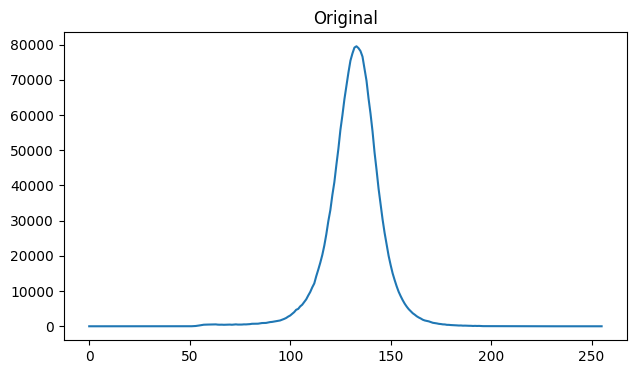

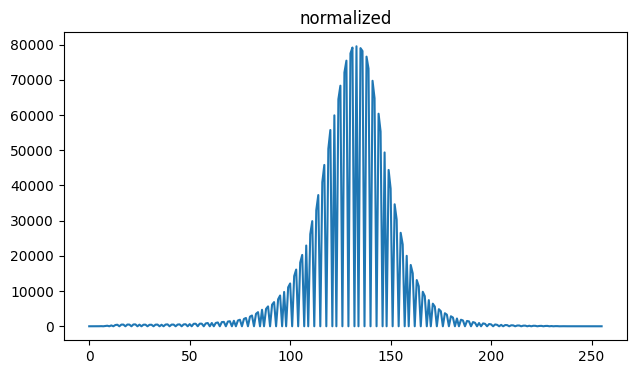

In [ ]:
img = cv2.imread('/content/0.05-No/0.05-No-0001.jpg', cv2.IMREAD_GRAYSCALE)
img_norm = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

hist = cv2.calcHist([img], [0], None, [256], [0, 256])
hist_norm = cv2.calcHist([img_norm], [0], None, [256], [0, 256])

# cv2_imshow(img)
# cv2_imshow(img_norm)

hists = {'Original' : hist, 'normalized':hist_norm }
for i, (k, v) in enumerate(hists.items()):
    plt.figure(figsize=(16,4))
    plt.subplot(1,2,i+1)
    plt.title(k)
    plt.plot(v)
plt.show()


In [ ]:
with tf.device('/device:GPU:0'):
  tf.model = tf.keras.Sequential()

  tf.model.add(tf.keras.layers.Conv1D(filters=32, input_shape=(255,1), kernel_size=3, kernel_initializer='glorot_normal', activation='relu', padding='same'))
  tf.model.add(tf.keras.layers.MaxPooling1D(pool_size=2)) # pool_size = (filter_size, stride)
  tf.model.add(tf.keras.layers.Dropout(0.2)) # Added Dropout Layer

  tf.model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, kernel_initializer='glorot_normal', activation='relu', padding='same'))
  tf.model.add(tf.keras.layers.Dropout(0.2)) # Added Dropout Layer
  tf.model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, kernel_initializer='glorot_normal', activation='relu', padding='same'))
  tf.model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
  tf.model.add(tf.keras.layers.Dropout(0.2)) # Added Dropout Layer

  tf.model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, kernel_initializer='glorot_normal', activation='relu', padding='same'))
  tf.model.add(tf.keras.layers.Dropout(0.2)) # Added Dropout Layer
  tf.model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, kernel_initializer='glorot_normal', activation='relu', padding='same'))
  tf.model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
  tf.model.add(tf.keras.layers.Dropout(0.2)) # Added Dropout Layer

  tf.model.add(tf.keras.layers.Flatten()) # 3D data -> 1D data
  tf.model.add(tf.keras.layers.Dense(units=1, kernel_initializer='glorot_normal', activation='sigmoid'))

  tf.model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])
  tf.model.summary()

  # Train
  start = datetime.datetime.now()
  run_results = tf.model.fit(x_histo, y_train, validation_split=0.15, batch_size=32, epochs=100)
  end = datetime.datetime.now()
  time = end - start
  print("모델 훈련 시간 :", time)


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_82 (Conv1D)          (None, 255, 32)           128       
                                                                 
 max_pooling1d_54 (MaxPoolin  (None, 127, 32)          0         
 g1D)                                                            
                                                                 
 dropout_72 (Dropout)        (None, 127, 32)           0         
                                                                 
 conv1d_83 (Conv1D)          (None, 127, 64)           6208      
                                                                 
 dropout_73 (Dropout)        (None, 127, 64)           0         
                                                                 
 conv1d_84 (Conv1D)          (None, 127, 64)           12352     
                                                     

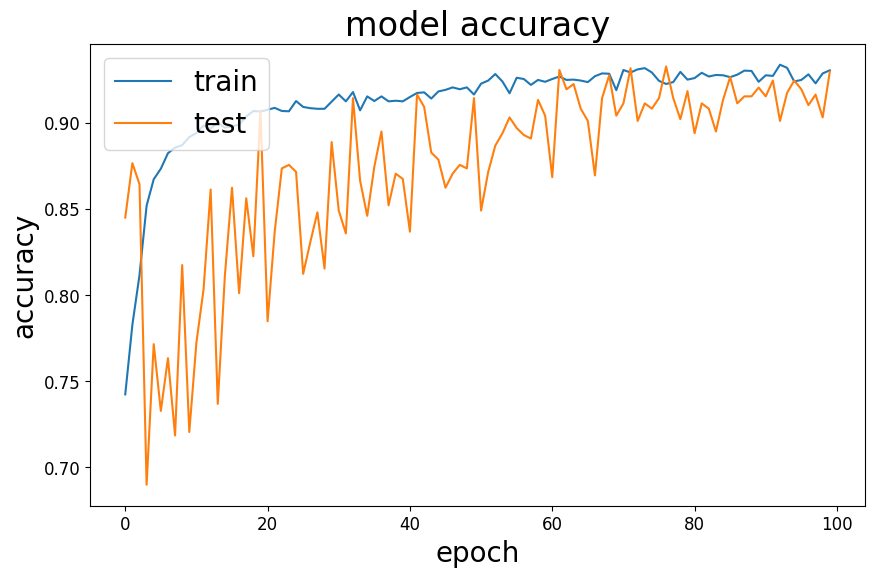

In [ ]:
# summarize history for accuracy
plt.figure(figsize=(10, 6))
plt.plot(run_results.history['accuracy'])
plt.plot(run_results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Accuracy
Train_Accuracy = tf.model.evaluate(x_histo, y_train)
Test_Accuracy = tf.model.evaluate(x_histo_test, y_test)

36/36 [==============================] - 0s 2ms/step - loss: 0.2125 - accuracy: 0.9167


#### Show CNN output

All layer

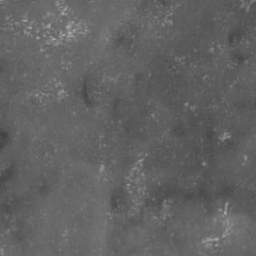

input histogram


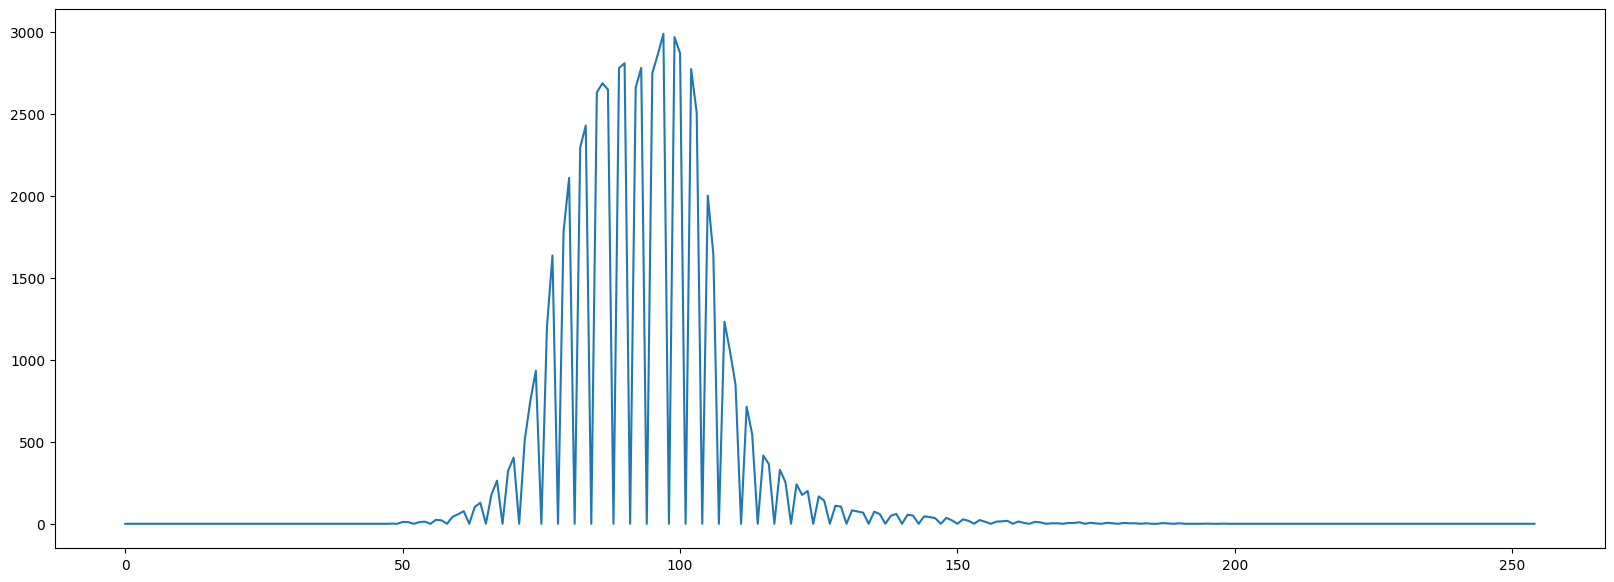

1/1 [==============================] - 0s 159ms/step
0 st layer


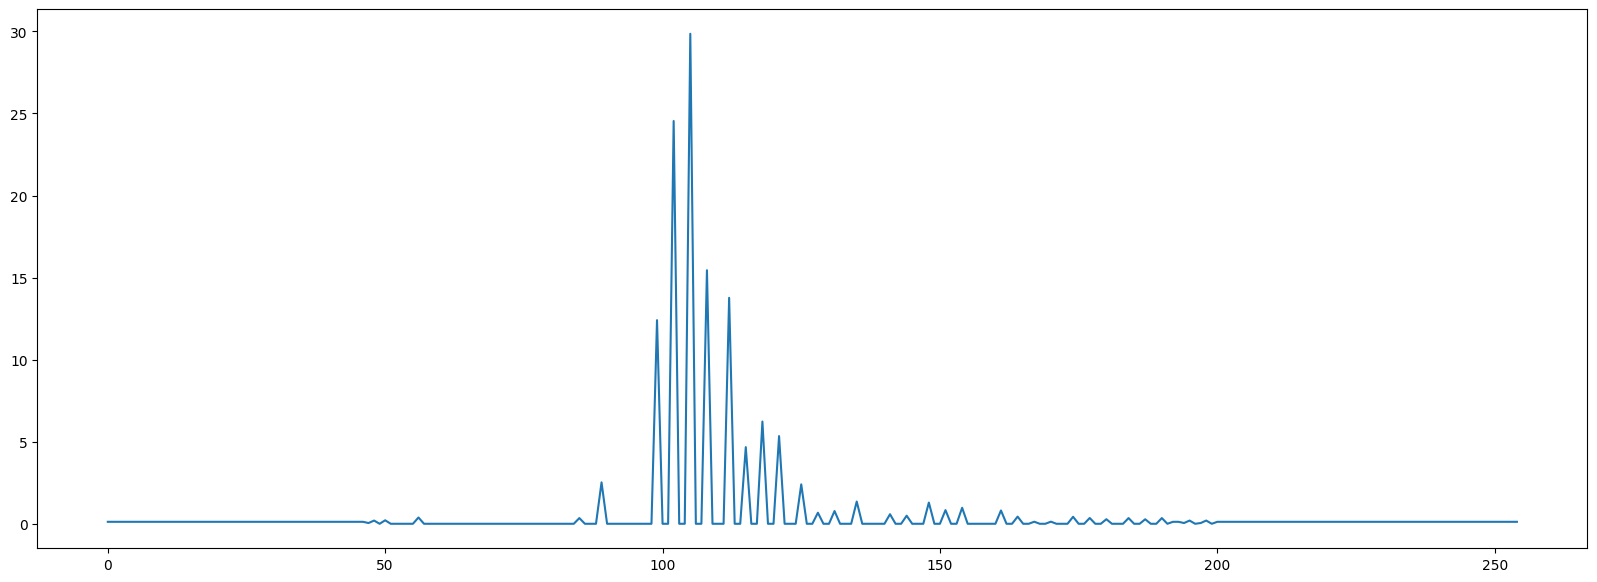

1 st layer


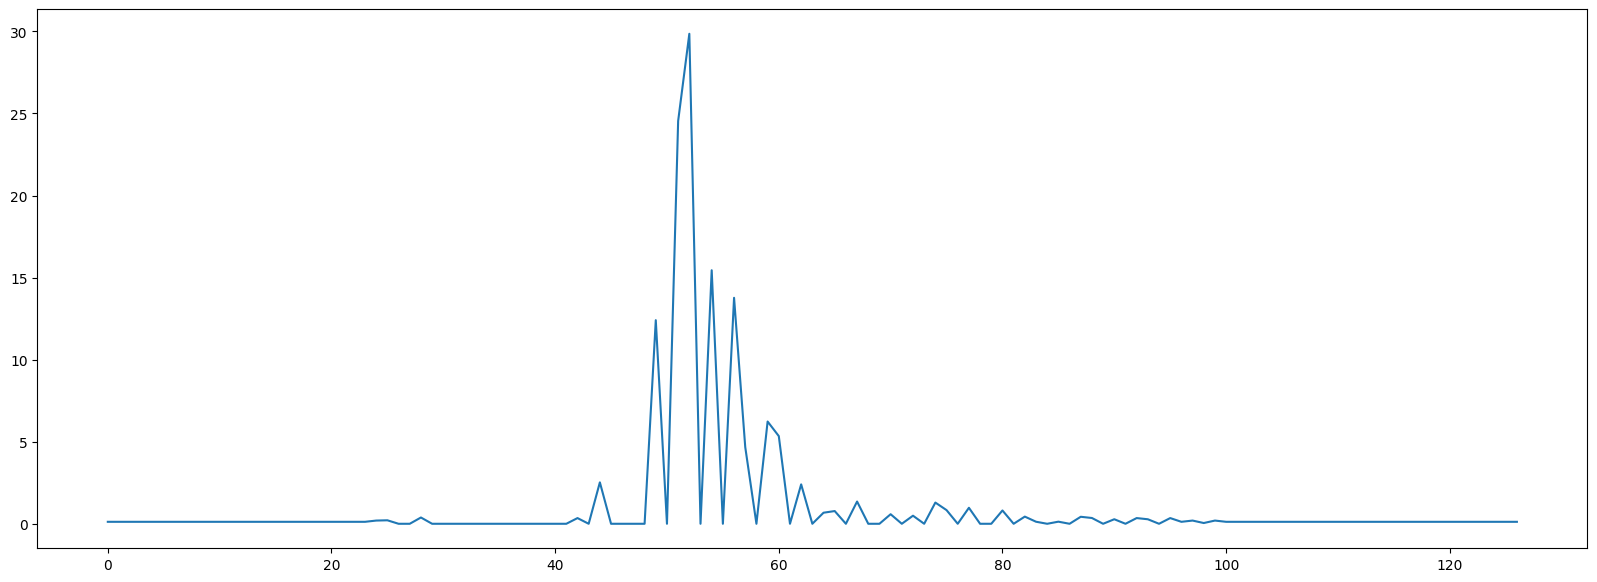

2 st layer


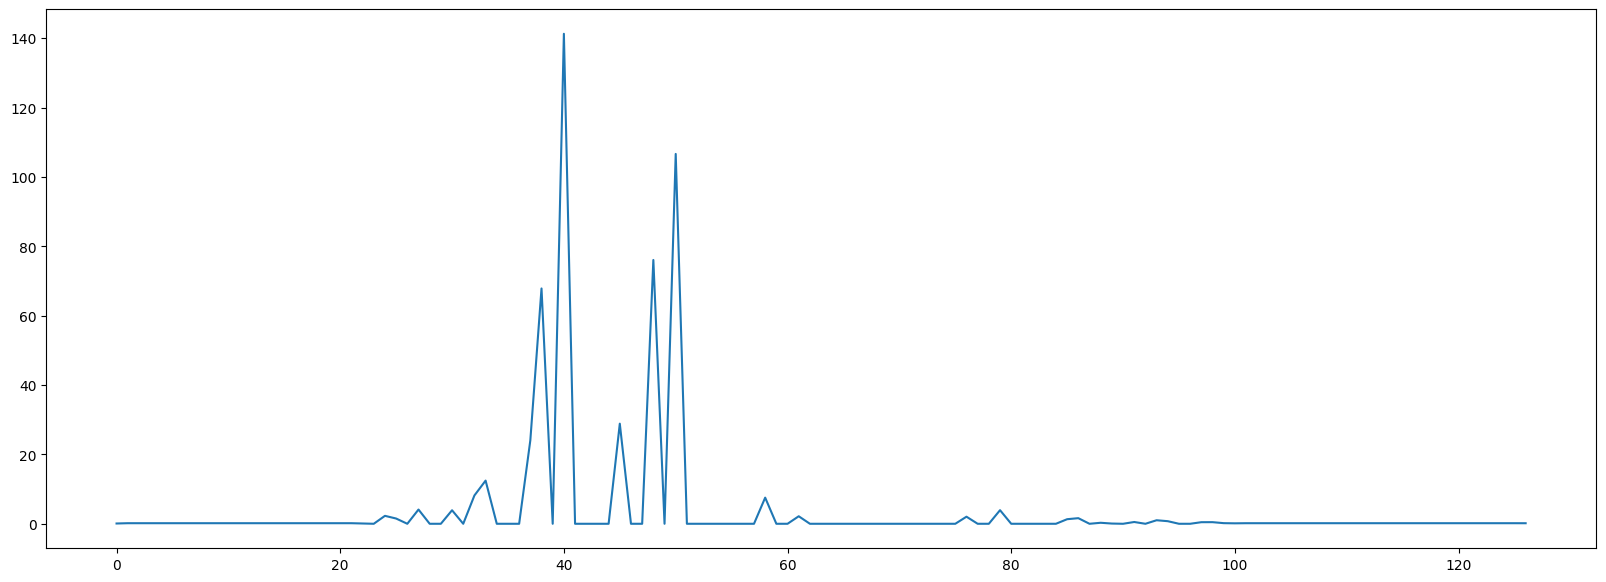

3 st layer


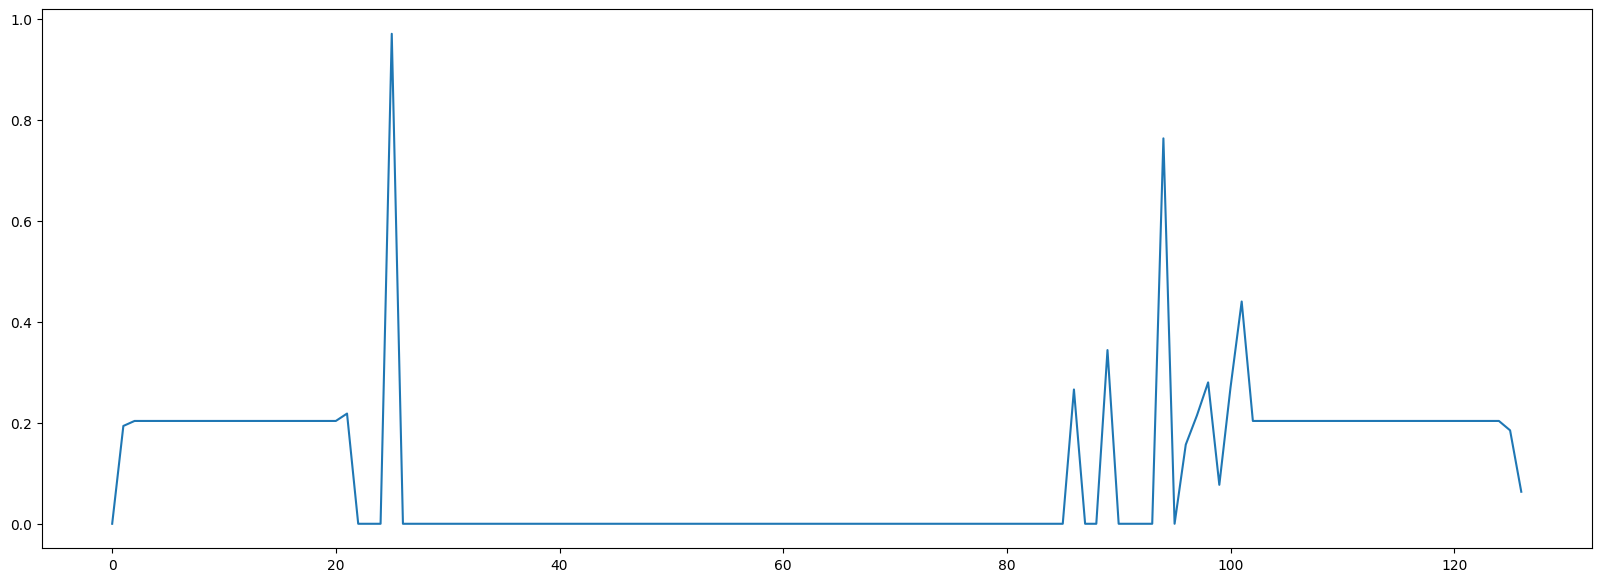

4 st layer


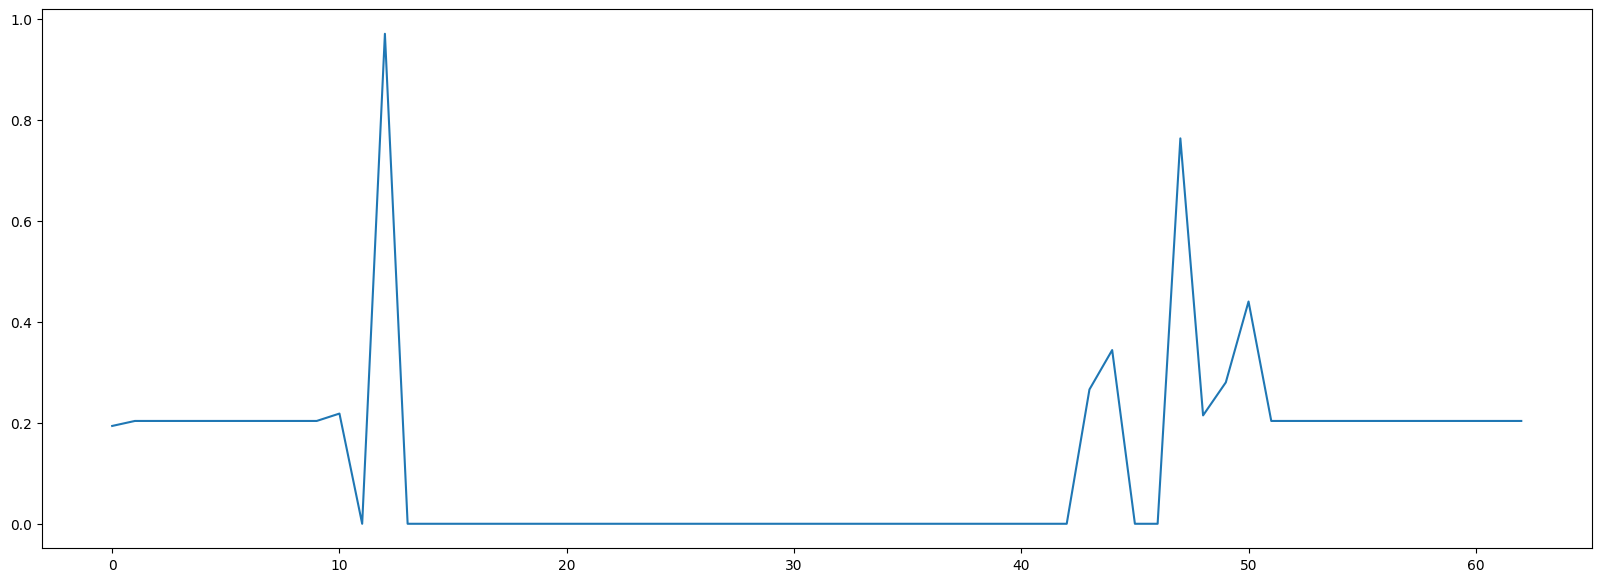

5 st layer


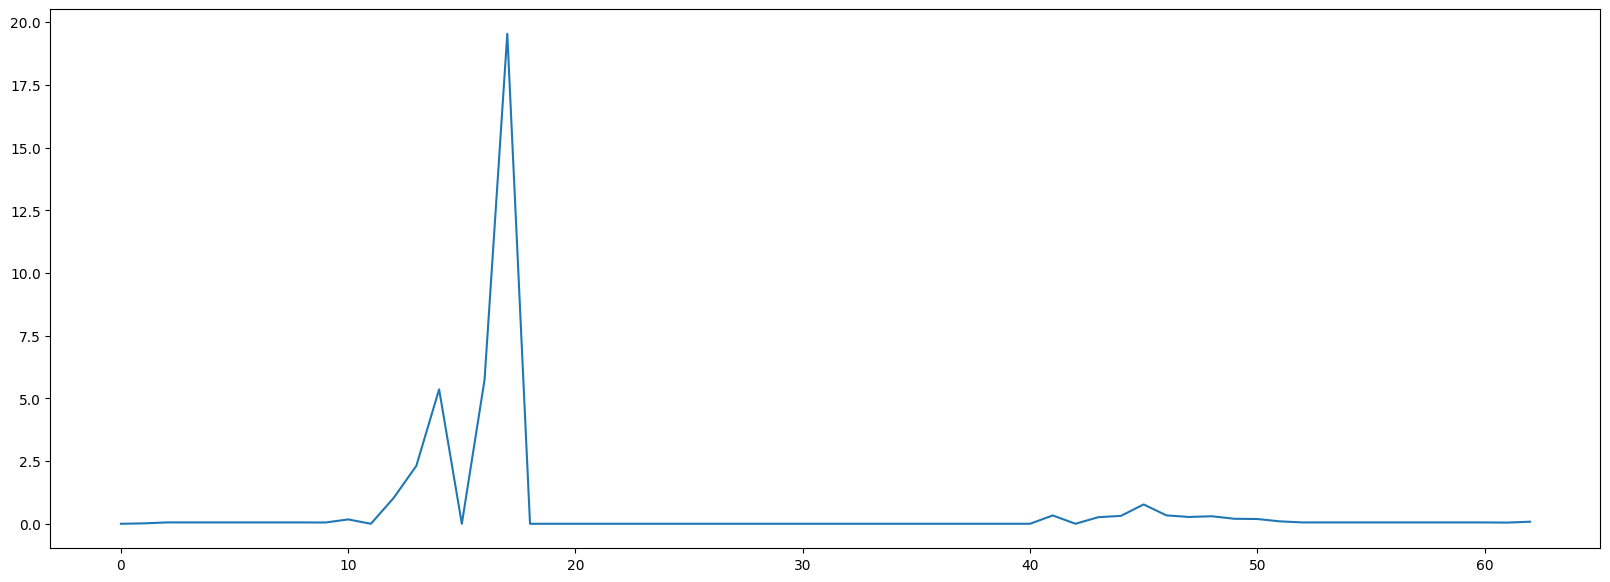

6 st layer


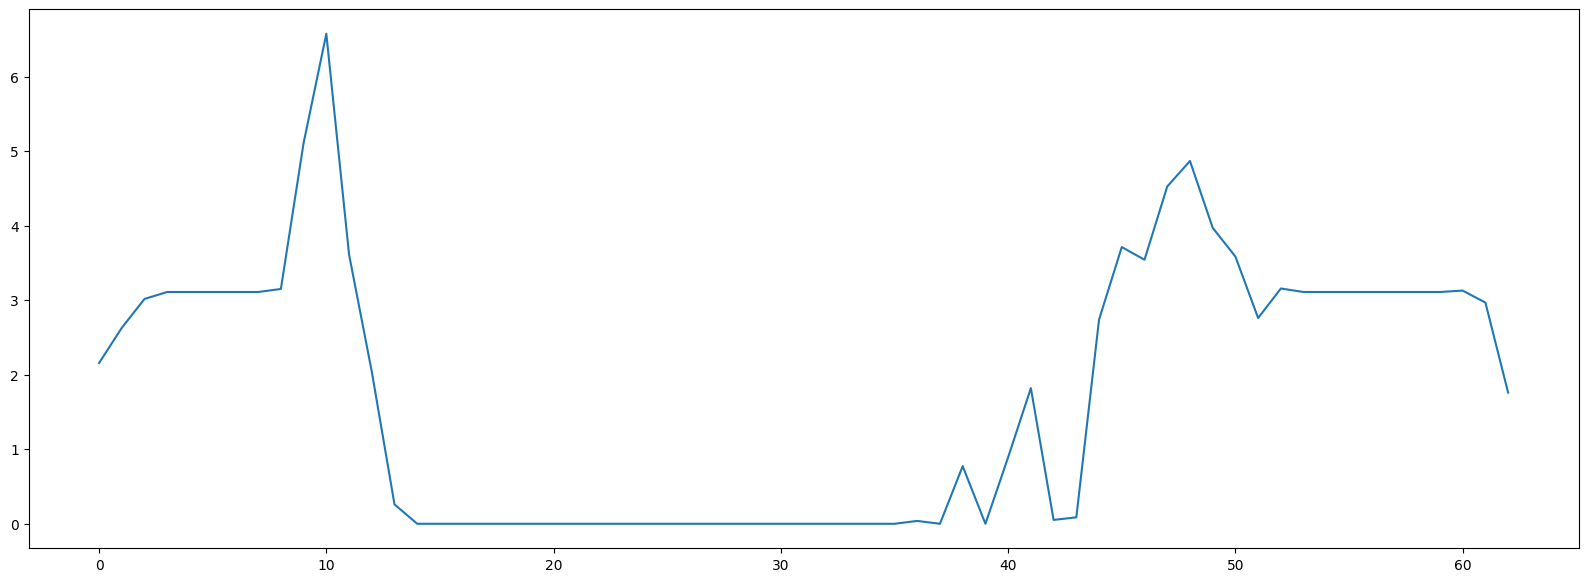

7 st layer


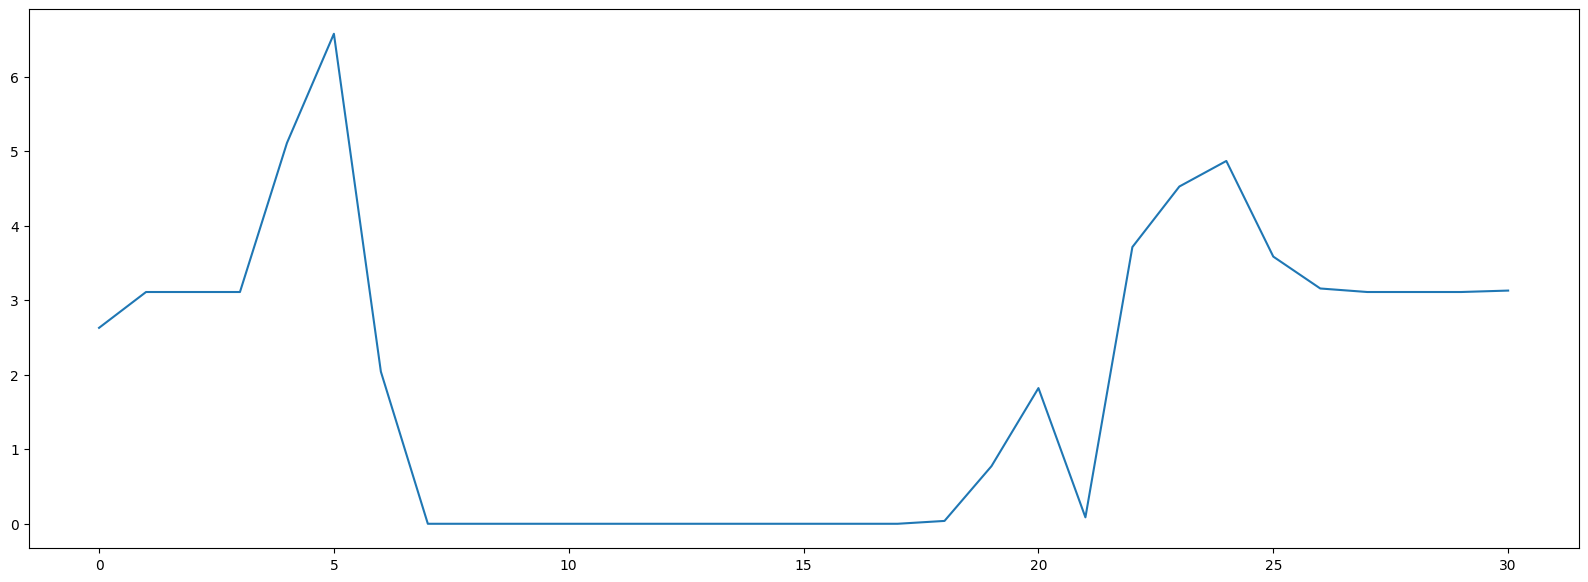

In [ ]:
#Define a new truncated model to only include the conv layers of interest
conv_layer_index = [0, 1, 2, 3,4, 5, 6,7]
outputs = [tf.model.layers[i].output for i in conv_layer_index]
show_output = Model(inputs=tf.model.inputs, outputs=outputs)

i = 0
cv2_imshow(x_train[i])
print("input histogram")
plt.plot(x_histo[i])
plt.show()
img = np.array(x_histo[i])
img = np.expand_dims(img, axis=0)
feature_output = show_output.predict(img)
n = len(conv_layer_index)
for j in range(n):
  ft = np.array(feature_output[j])
  print(j,"st layer")
  plt.plot(ft[0,:,3]) # second filter
  plt.show()

Last index

In [ ]:
i = 0   # 0.4

img = np.array(x_histo[i])
img = np.expand_dims(img, axis=0)
feature_output = tf.model.predict(img)

ft = np.array(feature_output[0])
ft

1/1 [==============================] - 0s 124ms/step


array([1.], dtype=float32)

#### Show diff

input histogram
1/1 [==============================] - 0s 115ms/step


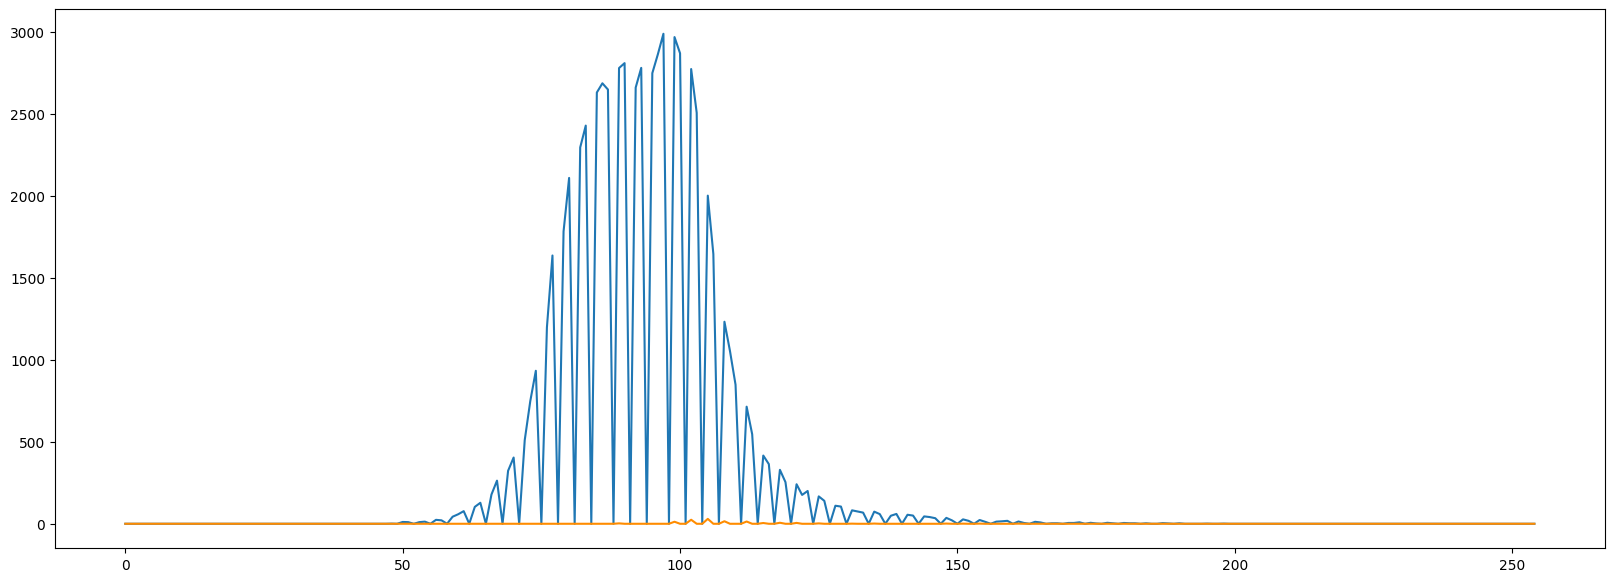

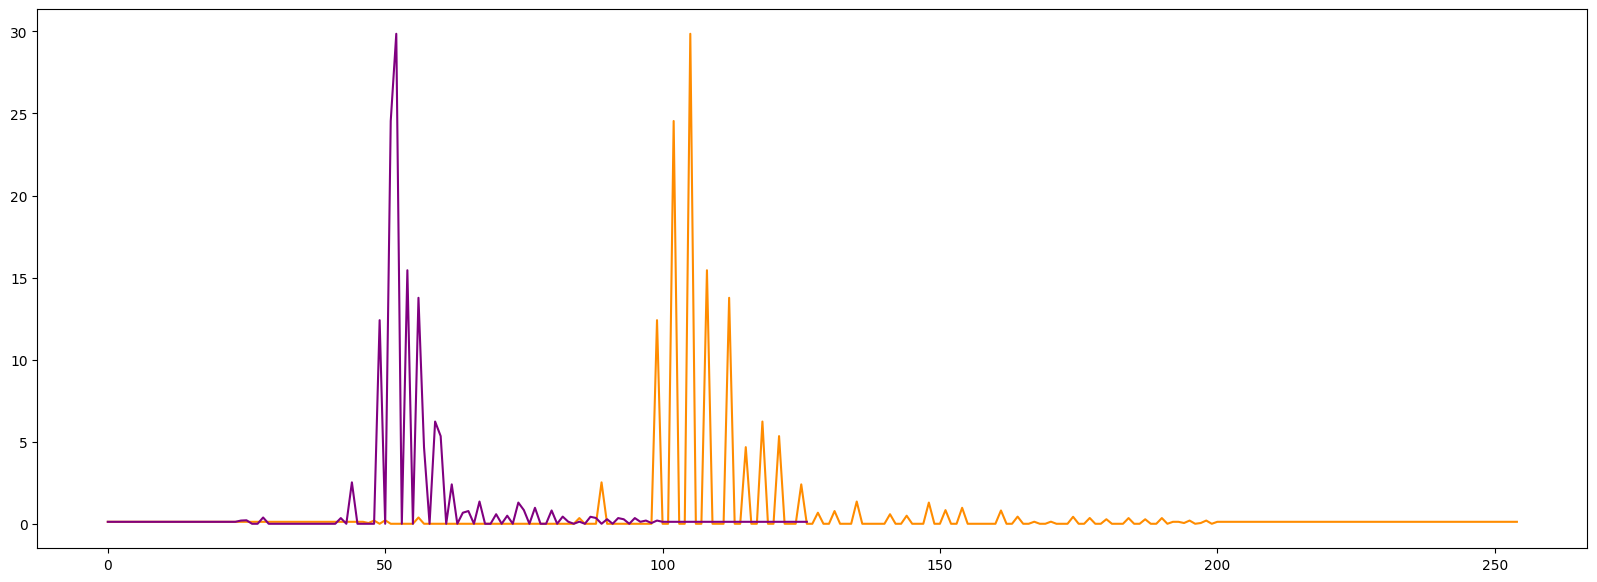

In [ ]:
#Define a new truncated model to only include the conv layers of interest
conv_layer_index = [0 ,1, 2, 3, 4, 5, 6, 7]
outputs = [tf.model.layers[i].output for i in conv_layer_index]
show_output = Model(inputs=tf.model.inputs, outputs=outputs)

i = 0   # 0.4

print("input histogram")
plt.plot(x_histo[i])
# plt.show()
img = np.array(x_histo[i])
img = np.expand_dims(img, axis=0)
feature_output = show_output.predict(img)

ft = np.array(feature_output[0])
plt.plot(ft[0,:,3],color='darkorange') # second filter
plt.show()

ft = np.array(feature_output[0])
plt.plot(ft[0,:,3], color='darkorange') # second filter
# plt.show()
ft = np.array(feature_output[1])
plt.plot(ft[0,:,3,], color='purple') # second filter
plt.show()

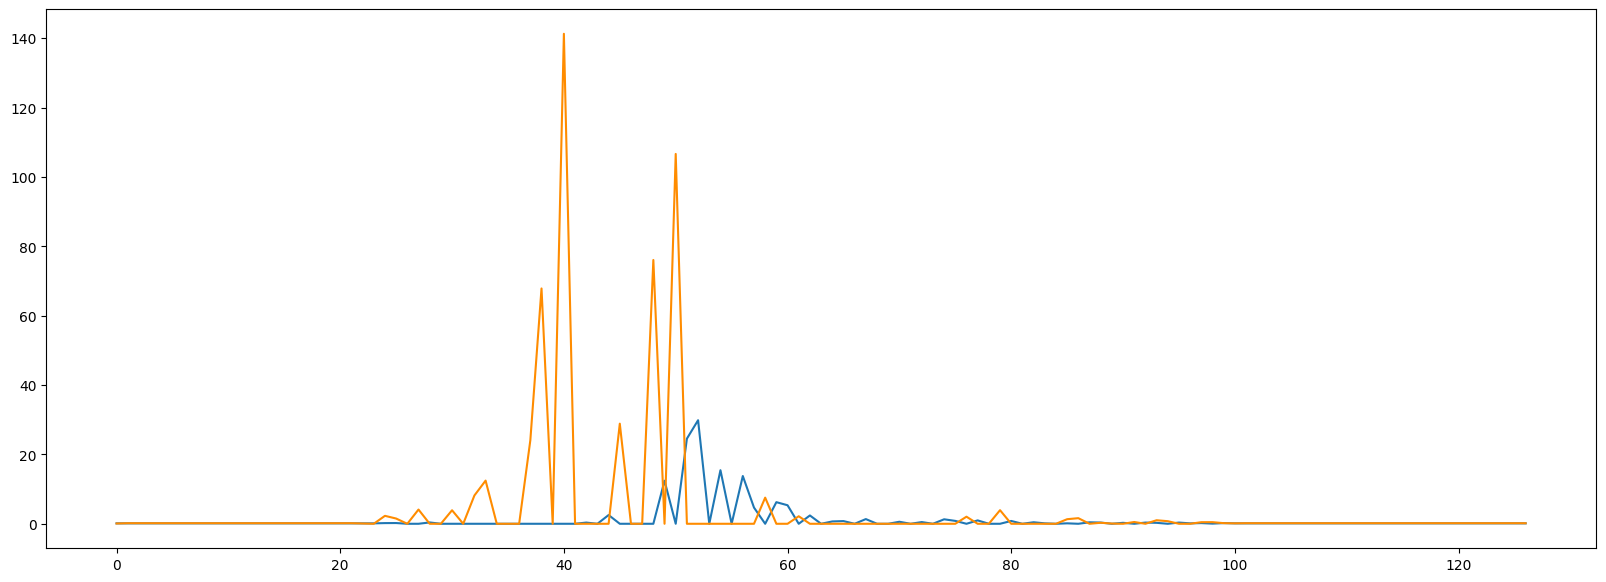

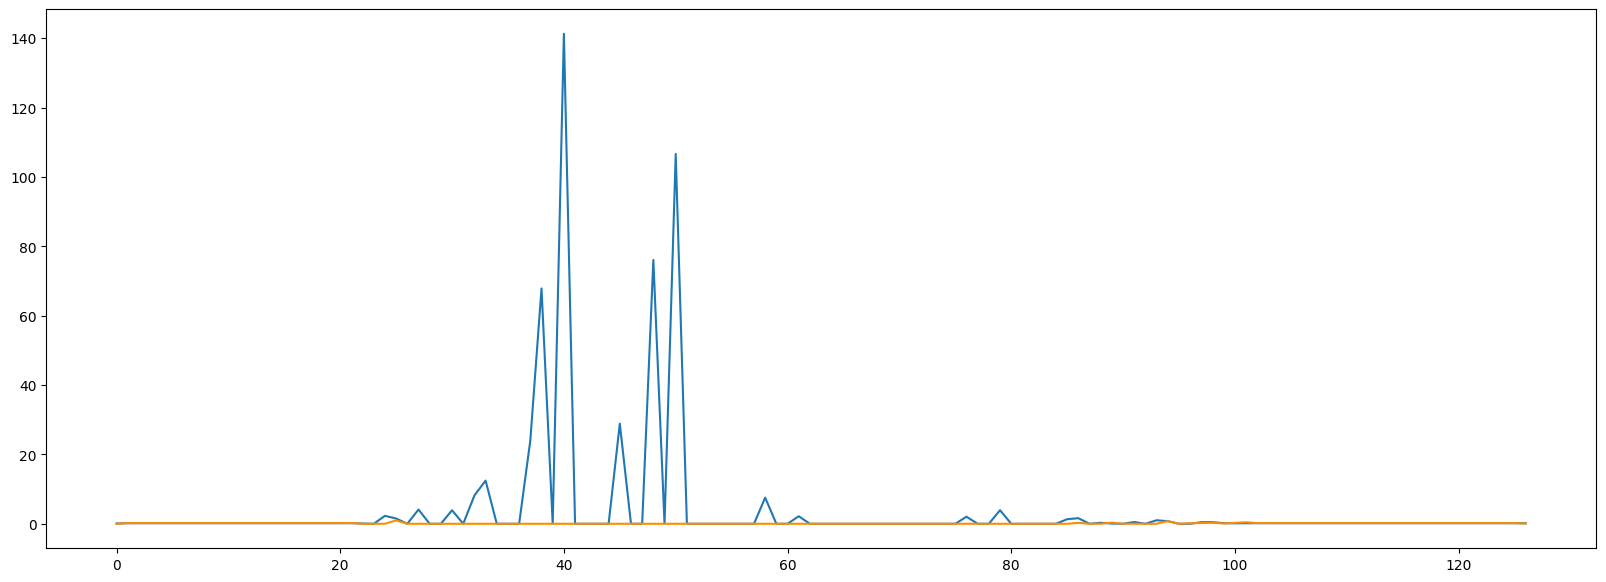

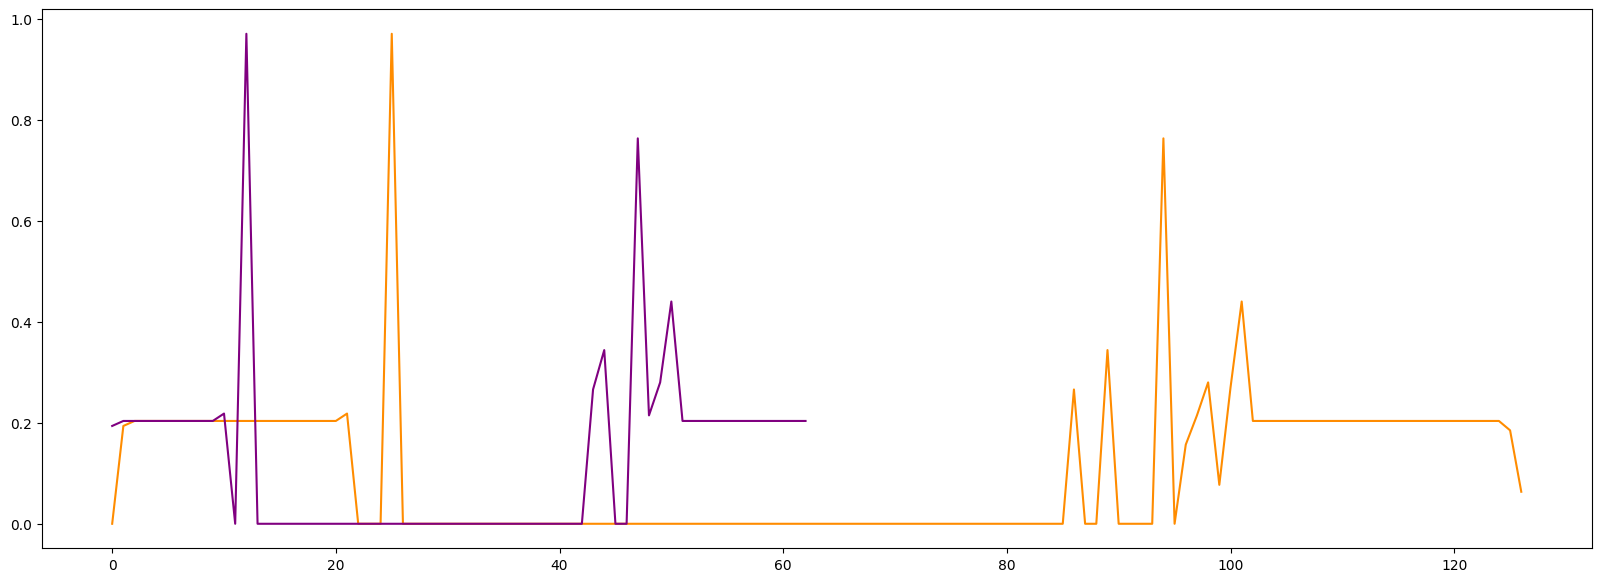

In [ ]:
ft = np.array(feature_output[1])
plt.plot(ft[0,:,3]) # second filter
# plt.show()
ft = np.array(feature_output[2])
plt.plot(ft[0,:,3], color='darkorange') # second filter
plt.show()

ft = np.array(feature_output[2])
plt.plot(ft[0,:,3,]) # second filter
# plt.show()
ft = np.array(feature_output[3])
plt.plot(ft[0,:,3],color='darkorange') # second filter
plt.show()

ft = np.array(feature_output[3])
plt.plot(ft[0,:,3], color='darkorange') # second filter
# plt.show()
ft = np.array(feature_output[4])
plt.plot(ft[0,:,3,], color='purple') # second filter
plt.show()

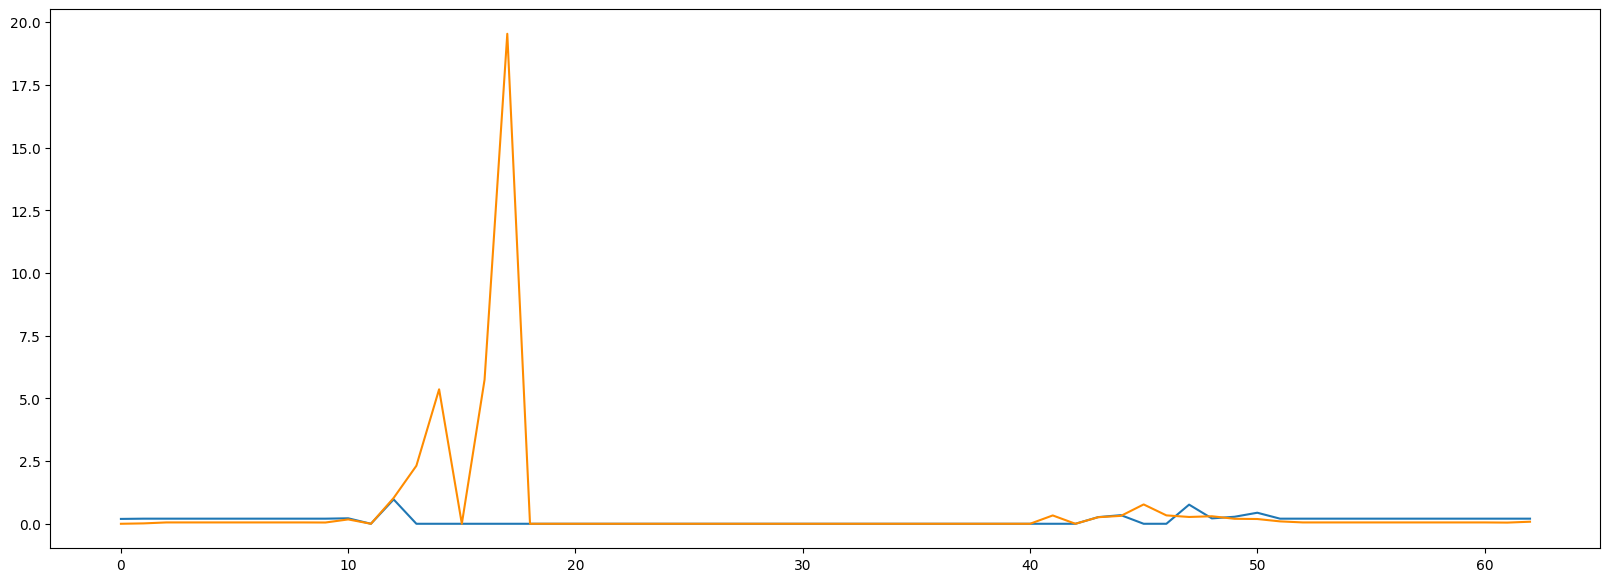

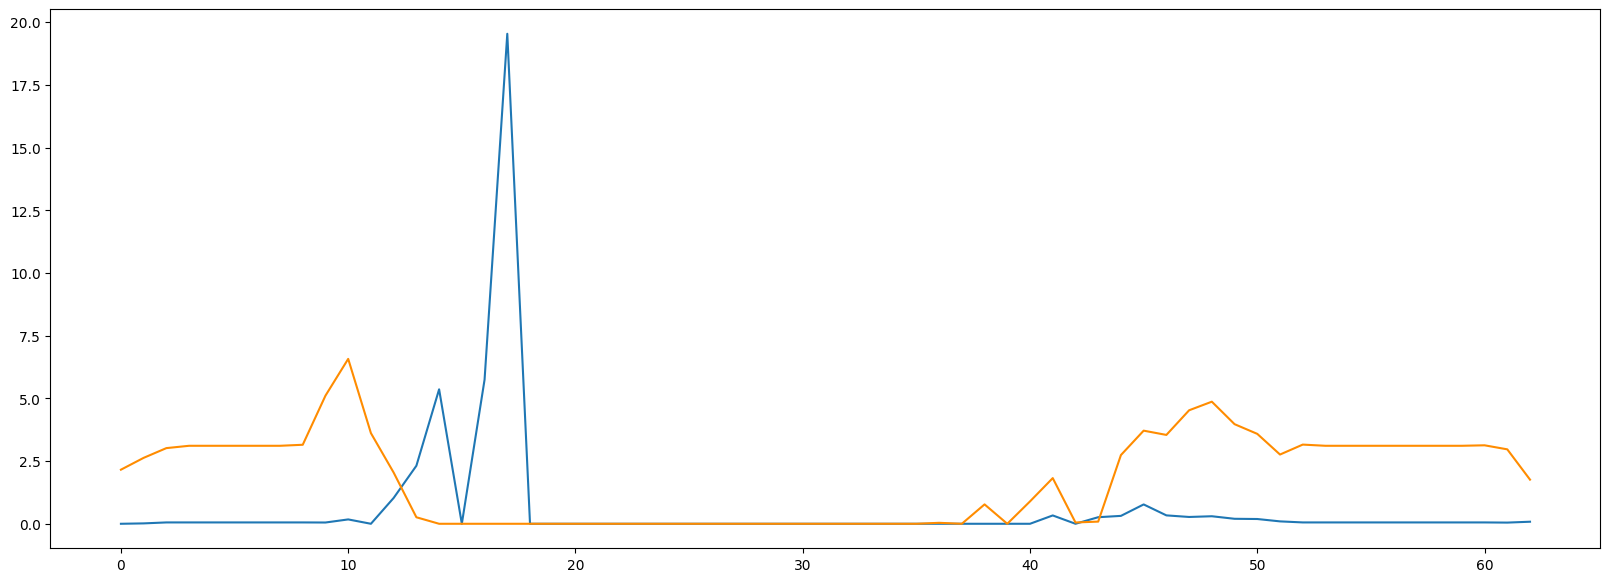

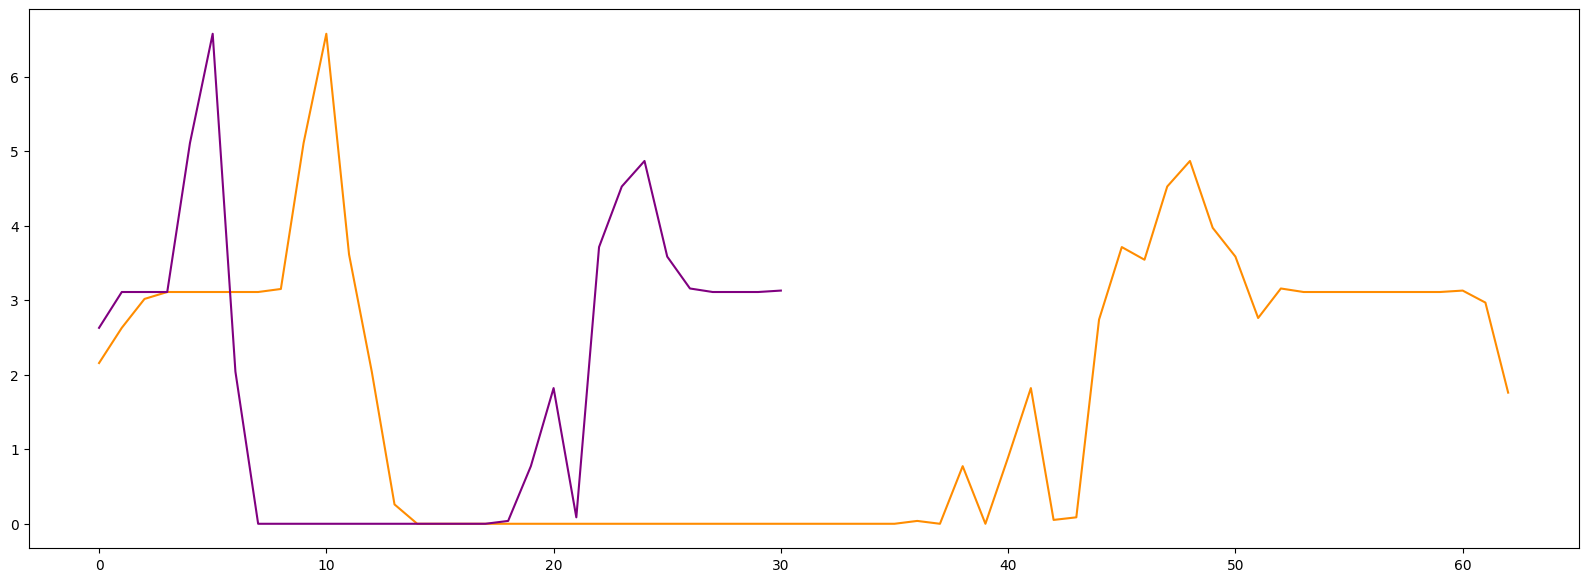

In [ ]:
ft = np.array(feature_output[4])
plt.plot(ft[0,:,3]) # second filter
# plt.show()
ft = np.array(feature_output[5])
plt.plot(ft[0,:,3], color='darkorange') # second filter
plt.show()

ft = np.array(feature_output[5])
plt.plot(ft[0,:,3,]) # second filter
# plt.show()
ft = np.array(feature_output[6])
plt.plot(ft[0,:,3],color='darkorange') # second filter
plt.show()

ft = np.array(feature_output[6])
plt.plot(ft[0,:,3], color='darkorange') # second filter
# plt.show()
ft = np.array(feature_output[7])
plt.plot(ft[0,:,3,], color='purple') # second filter
plt.show()

#### Prediction

In [ ]:
# Predict Test Set
Prediction = []

for pred in tf.model.predict(x_histo_test):
    if pred > 0.5:
        Prediction.append('Sonic')
    else:
        Prediction.append('No')

36/36 [==============================] - 0s 2ms/step


In [ ]:
Prediction_int = []
Son_count = 0
No_count = 0

for i in Prediction:
  if i == 'No':
    Prediction_int.append(0)
    No_count += 1

  elif i == 'Sonic':
    Prediction_int.append(1)
    Son_count += 1

In [ ]:
# Define CM graph
def show_cm(title,cm):
    mpl.rcParams['font.size']=20
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

    # setting font size
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=12)

    plt.title(f"Confusion Matirx of {title}")
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.xticks([0.5,1.5], ['No Sonication','Sonication'])
    plt.yticks([0.5,1.5], ['No Sonication','Sonication'])
    plt.show()

In [ ]:
Prediction=tf.model.predict(x_histo_test)

36/36 [==============================] - 0s 2ms/step


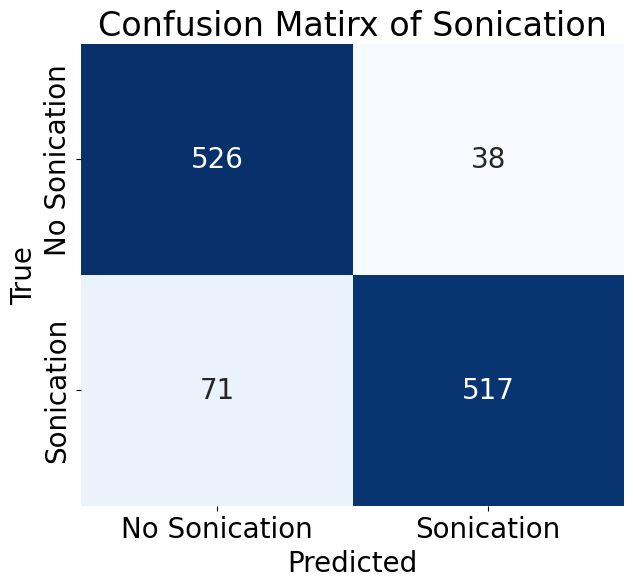

Accuracy: 90.5%


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, Prediction_int)
show_cm('Sonication', cm)  # 대각선이 올바르게 예측한 경우
print(f'Accuracy: {accuracy_score(y_test, Prediction_int)*100:0.1f}%')

### 2) CNT Content

In [ ]:
CURRENT = './'
CONTENTS = ['0.05', '0.1', '0.2', '0.4']  # CNT Powder Content
# CATEGORIES = ['No', 'Sonic']

In [ ]:
CNT_IMG = []

for content in CONTENTS:
      Path = CURRENT + content + '-Sonic'
      print(Path)

      for file in os.listdir(Path):
          # Change Image to Numpy array in grayscale
          img_array = cv2.imread(os.path.join(Path, file), cv2.IMREAD_GRAYSCALE)
          # 이미지 파일에, " CNT powder content, sonication 여부" 추가
          CNT_IMG.append([img_array, CONTENTS.index(content), file])

./0.05-Sonic
./0.1-Sonic
./0.2-Sonic
./0.4-Sonic


In [ ]:
len(CNT_IMG)

160

In [ ]:
# Four splits in row and six splits in column -> 24 small samples from one 1080 x 1920 image
n_row = 4
n_col = 6

# Resize image to 256 x 256 pixels
img_size = 256

SMALL_IMG = []

for img_array, content, name in CNT_IMG:
    for i in range(n_row):
        for k in range(n_col):
            height = int(img_array.shape[0]/n_row)
            width = int(img_array.shape[1]/n_col)

            small_img = img_array[i*height:(i+1)*height, k*width:(k+1)*width] # Split -> 270 x 320

            small_img = cv2.resize(small_img, (img_size, img_size)) # Resize -> 256 x 256

            # Normalization
            # small_img = small_img

            SMALL_IMG.append([small_img, content, name])

In [ ]:
len(SMALL_IMG)

3840

In [ ]:
# Shuffle images to be trained well
random.shuffle(SMALL_IMG)

In [ ]:
trainN = int(len(SMALL_IMG)*0.85)
print(trainN)
Train_Data = SMALL_IMG[:trainN]
Test_Data = SMALL_IMG[trainN:]

3264


In [ ]:
x_train = []
y_train = []  # 두 번째 출력값, CNT powder content

for img_array, content, name in Train_Data:
    x_train.append(img_array)
    y_train.append(content)

# Change List to Numpy
x_train = np.array(x_train).reshape(trainN, img_size, img_size, 1) # (instances, height, width, depth)
y_train = np.array(y_train)

print(x_train.shape, y_train.shape)

(3264, 256, 256, 1) (3264,)


In [ ]:
x_test = []
y_test = []

for img_array, content, name in Test_Data:
    x_test.append(img_array)
    y_test.append(content)

x_test = np.array(x_test).reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

print(x_test.shape, y_test.shape)

(576, 256, 256, 1) (576,)


In [ ]:
def to_one_hot(labels, dimension=4):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

y_train = to_one_hot(y_train) # 훈련 레이블 벡터 변환
y_test = to_one_hot(y_test) # 테스트 레이블 벡터 변환

In [ ]:
# 0~255 normalization
x_train_norm = (x_train - np.min(x_train))/(np.max(x_train)-np.min(x_train))*255
x_histo = np.array( [np.histogram(tmp, range(0,256))[0] for tmp in x_train_norm])
x_histo = np.expand_dims(x_histo, axis=2)

In [ ]:
# 0~255 normalization
x_test_norm = (x_test - np.min(x_test))/(np.max(x_test)-np.min(x_test))*255
x_histo_test = np.array( [np.histogram(tmp, range(0,256))[0] for tmp in x_test_norm])
x_histo_test = np.expand_dims(x_histo_test, axis=2)

In [ ]:
with tf.device('/device:GPU:0'):
  tf.model = tf.keras.Sequential()

  tf.model.add(tf.keras.layers.Conv1D(filters=32, input_shape=(255,1), kernel_size=3,
                                    kernel_initializer='he_normal',activation='relu', padding='same'))
  tf.model.add(tf.keras.layers.Dropout(0.2))
  tf.model.add(tf.keras.layers.MaxPooling1D(pool_size=2)) # pool_size = (filter_size, stride)

  tf.model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, kernel_initializer='he_normal',
                                    activation='relu', padding='same'))
  tf.model.add(tf.keras.layers.Dropout(0.2))
  tf.model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, kernel_initializer='he_normal',
                                    activation='relu', padding='same'))
  tf.model.add(tf.keras.layers.Dropout(0.2))
  tf.model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

  tf.model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, kernel_initializer='he_normal',
                                    activation='relu', padding='same'))
  tf.model.add(tf.keras.layers.Dropout(0.2))
  tf.model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, kernel_initializer='he_normal',
                                    activation='relu', padding='same'))
  tf.model.add(tf.keras.layers.Dropout(0.2))
  tf.model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

  tf.model.add(tf.keras.layers.Flatten()) # 3D data -> 1D data
  tf.model.add(tf.keras.layers.Dense(units=4, kernel_initializer='he_normal', activation='softmax'))

  tf.model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])
  tf.model.summary()

  # Train
  start = datetime.datetime.now()
  run_results = tf.model.fit(x_histo, y_train, validation_split=0.1, batch_size=32, epochs=200)
  end = datetime.datetime.now()
  time = end - start
  print("모델 훈련 시간 :", time)


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_87 (Conv1D)          (None, 255, 32)           128       
                                                                 
 dropout_77 (Dropout)        (None, 255, 32)           0         
                                                                 
 max_pooling1d_57 (MaxPoolin  (None, 127, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_88 (Conv1D)          (None, 127, 64)           6208      
                                                                 
 dropout_78 (Dropout)        (None, 127, 64)           0         
                                                                 
 conv1d_89 (Conv1D)          (None, 127, 64)           12352     
                                                     

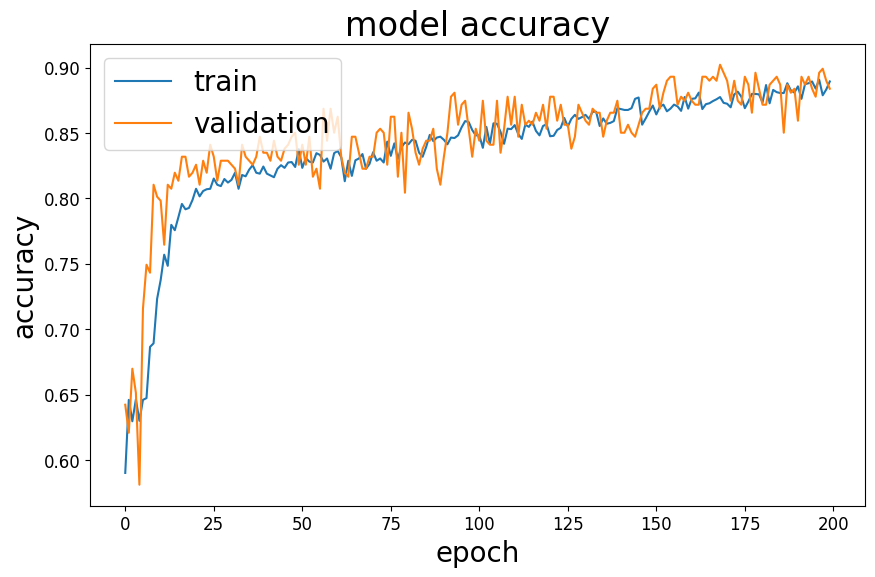

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(run_results.history['accuracy'])
plt.plot(run_results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Accuracy
Train_Accuracy = tf.model.evaluate(x_histo, y_train)
Test_Accuracy = tf.model.evaluate(x_histo_test, y_test)

18/18 [==============================] - 0s 3ms/step - loss: 0.3463 - accuracy: 0.8924


#### Save model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tf.model.save('/content/drive/MyDrive/MSML/CNT/(2)content model')

Plot filter outputs

In [ ]:
len(x_histo), len(x_histo[0]), len(x_histo[0][0])

(3260, 255, 1)

conv1d (3, 1, 32)


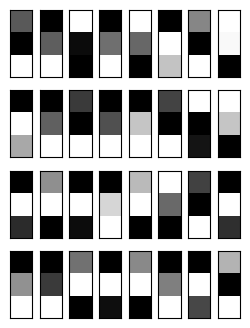

In [ ]:
#Understand the filters in the model
#Let us pick the first hidden layer as the layer of interest.
layer = tf.model.layers
filters, biases = tf.model.layers[0].get_weights()
print(layer[0].name, filters.shape)
fig1=plt.figure(figsize=(3, 4))
columns = 8
rows = 4
n_filters = columns * rows
for i in range(1, n_filters +1):
    f = filters[:, :,i-1]
    fig1 =plt.subplot(rows, columns, i)
    fig1.set_xticks([])  #Turn off axis
    fig1.set_yticks([])
    plt.imshow(f[:, :], cmap='gray') #Show only the filters from 0th channel (R)
    #ix += 1
plt.show()

Per content, plot image convertion

In [ ]:
a = pd.DataFrame(y_train)
a[:10]

,0,1,2,3
0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0
5,1.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0
7,0.0,0.0,1.0,0.0
8,1.0,0.0,0.0,0.0
9,0.0,1.0,0.0,0.0


In [ ]:
label_case = [1, 9, 4, 0] # ['0.05', '0.1', '0.2', '0.4']  # CNT Powder Content

array([1., 0., 0., 0.])

##### (1) 0.4

In [ ]:
layer = tf.model.layers
for i in range(len(layer)):
  print(layer[i].name)

conv1d
max_pooling1d
conv1d_1
conv1d_2
max_pooling1d_1
conv1d_3
conv1d_4
max_pooling1d_2
flatten
dense


Only convolution layer

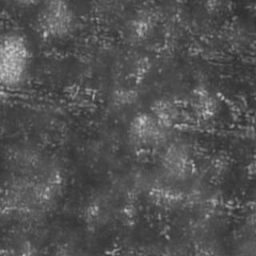

input histogram


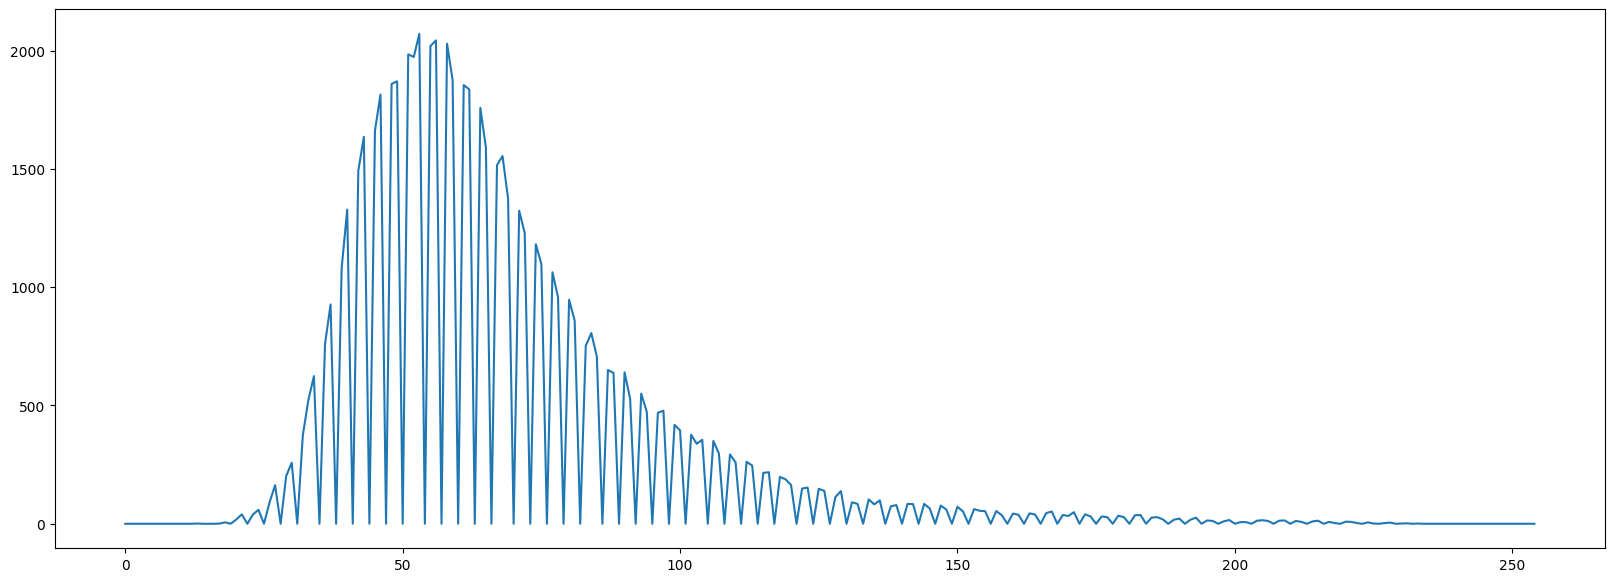

1/1 [==============================] - 0s 141ms/step
0 st layer


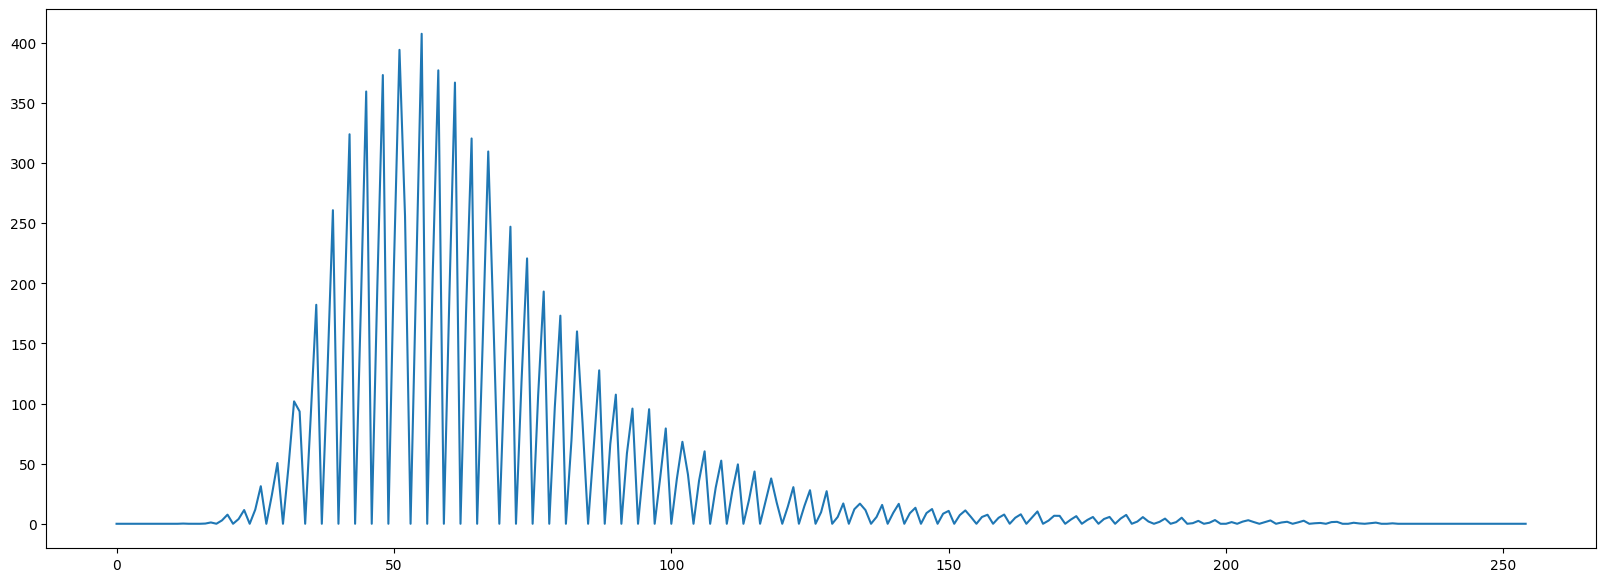

1 st layer


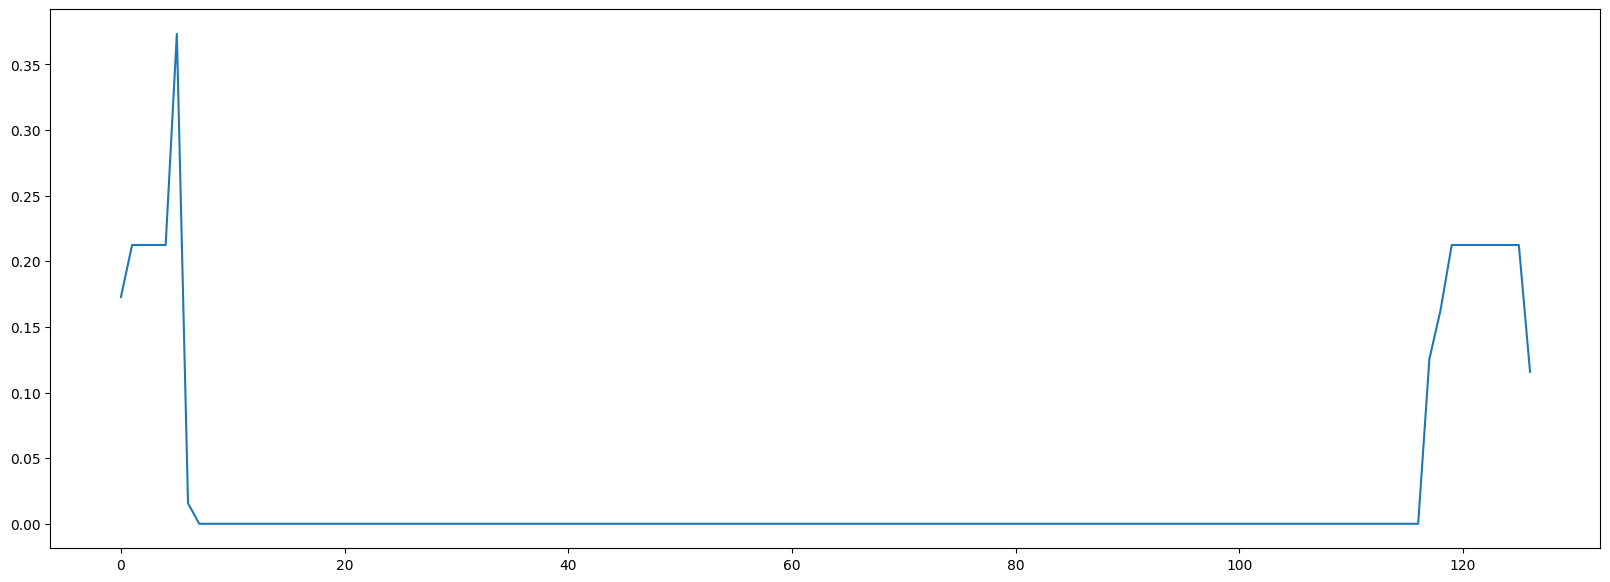

2 st layer


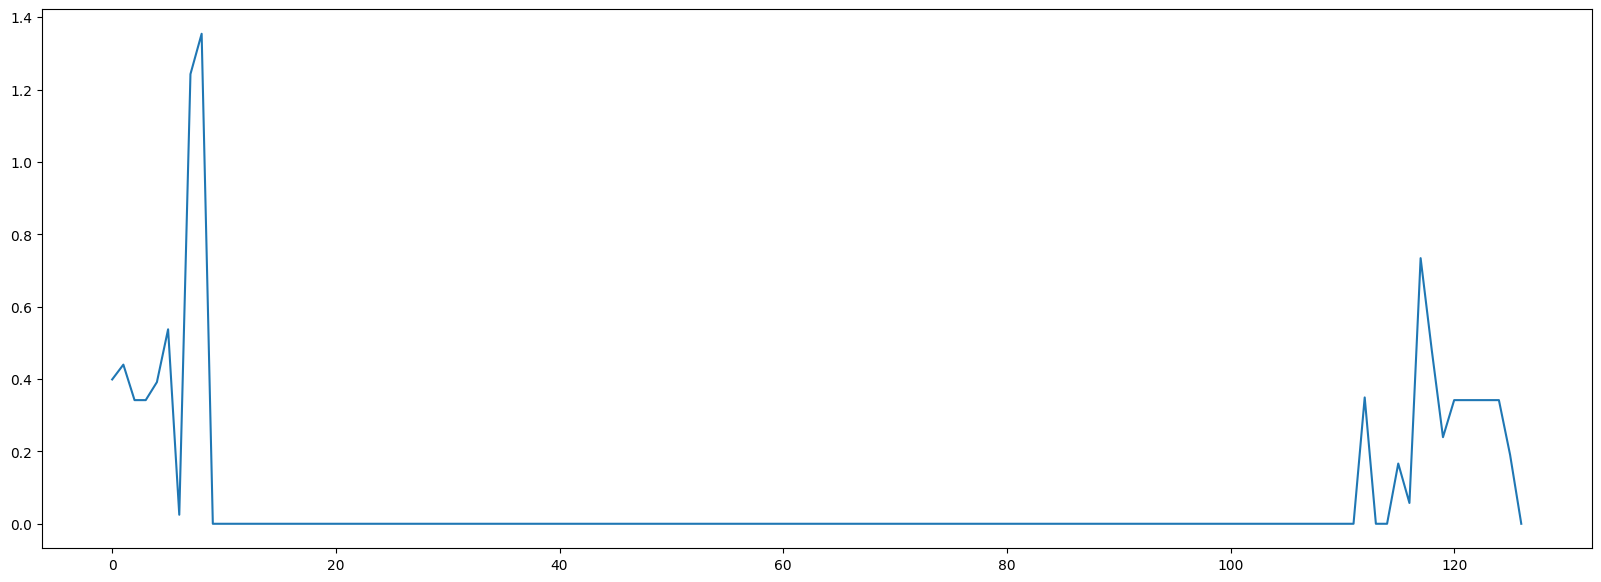

3 st layer


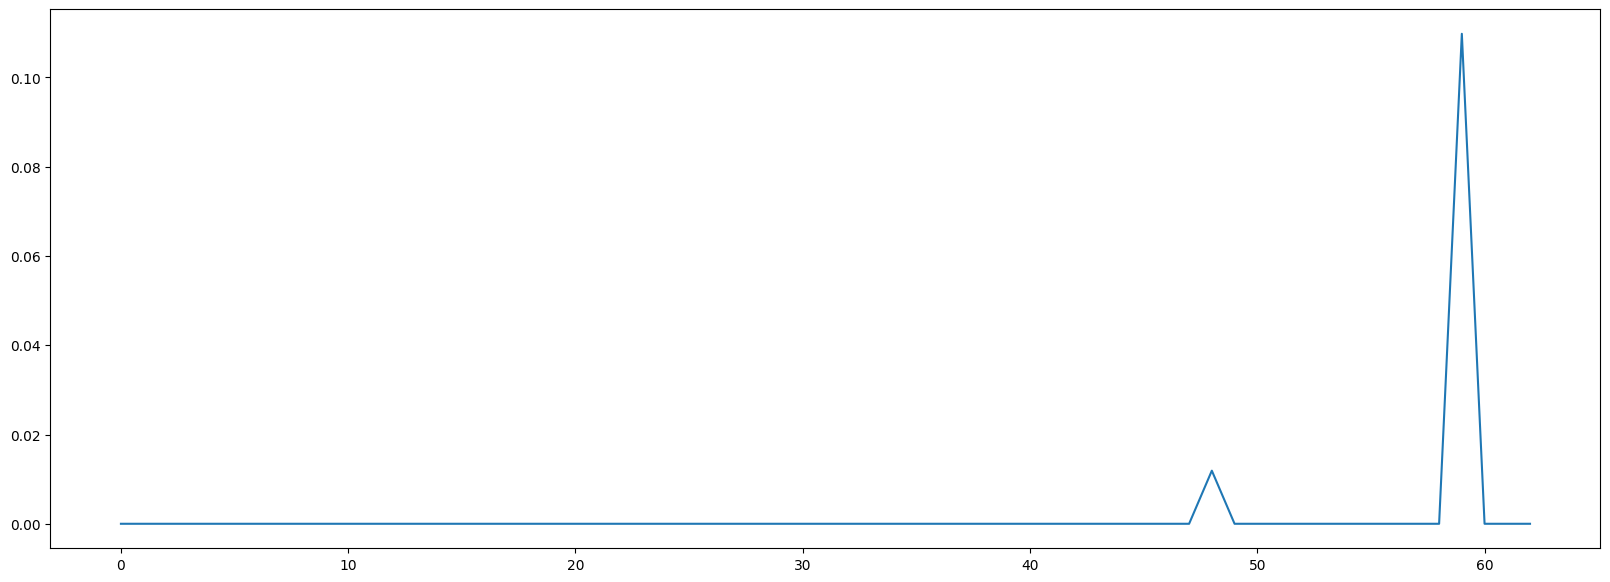

4 st layer


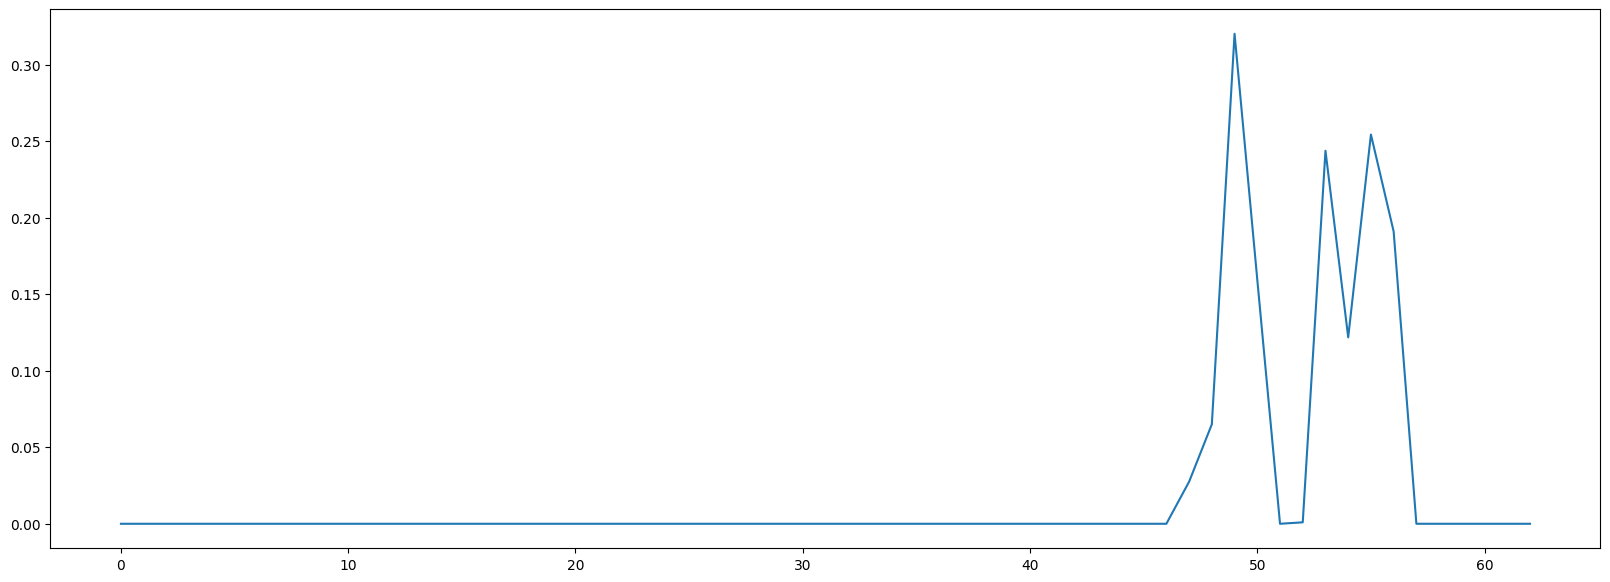

In [ ]:
#Define a new truncated model to only include the conv layers of interest
conv_layer_index = [0, 2, 3, 5, 6]
outputs = [tf.model.layers[i].output for i in conv_layer_index]
show_output = Model(inputs=tf.model.inputs, outputs=outputs)

i = 0   # 0.4
cv2_imshow(x_train[i])
print("input histogram")
plt.plot(x_histo[i])
plt.show()
img = np.array(x_histo[i])
img = np.expand_dims(img, axis=0)
feature_output = show_output.predict(img)
n = len(conv_layer_index)
for j in range(n):
  ft = np.array(feature_output[j])
  print(j,"st layer")
  plt.plot(ft[0,:,1]) # second filter
  plt.show()

##### Show diff

input histogram
1/1 [==============================] - 0s 356ms/step


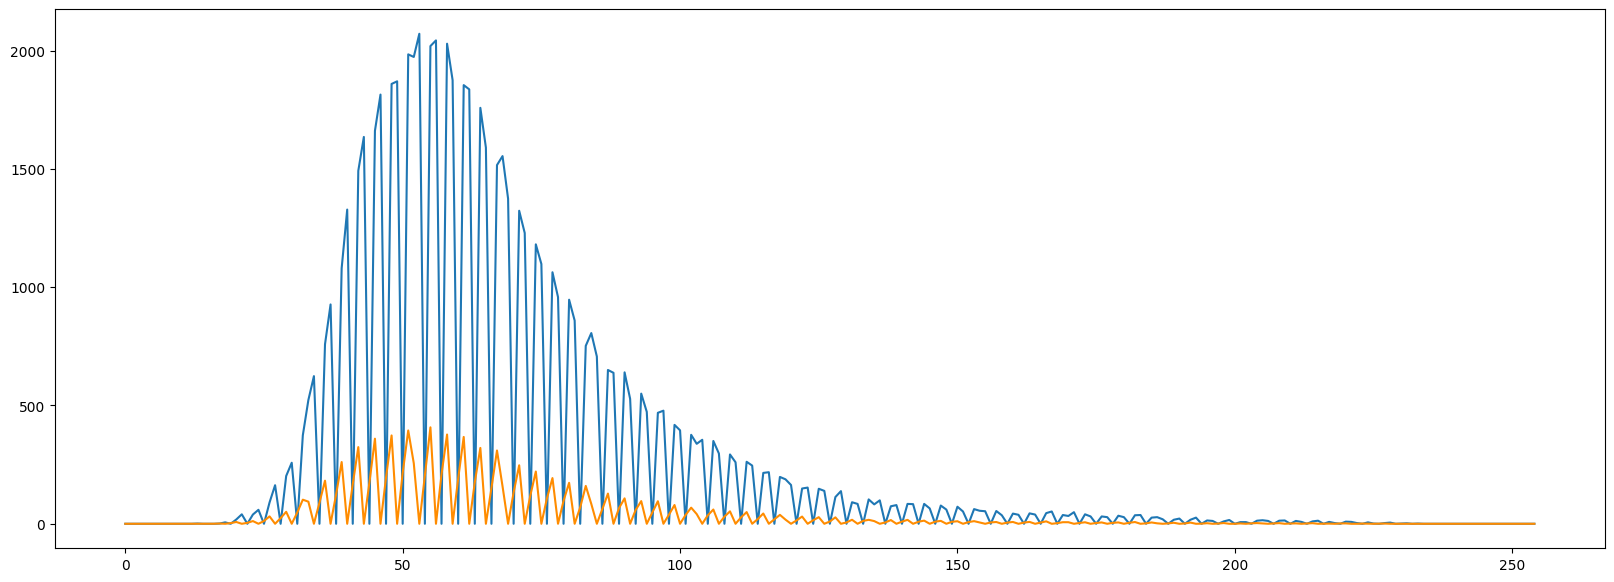

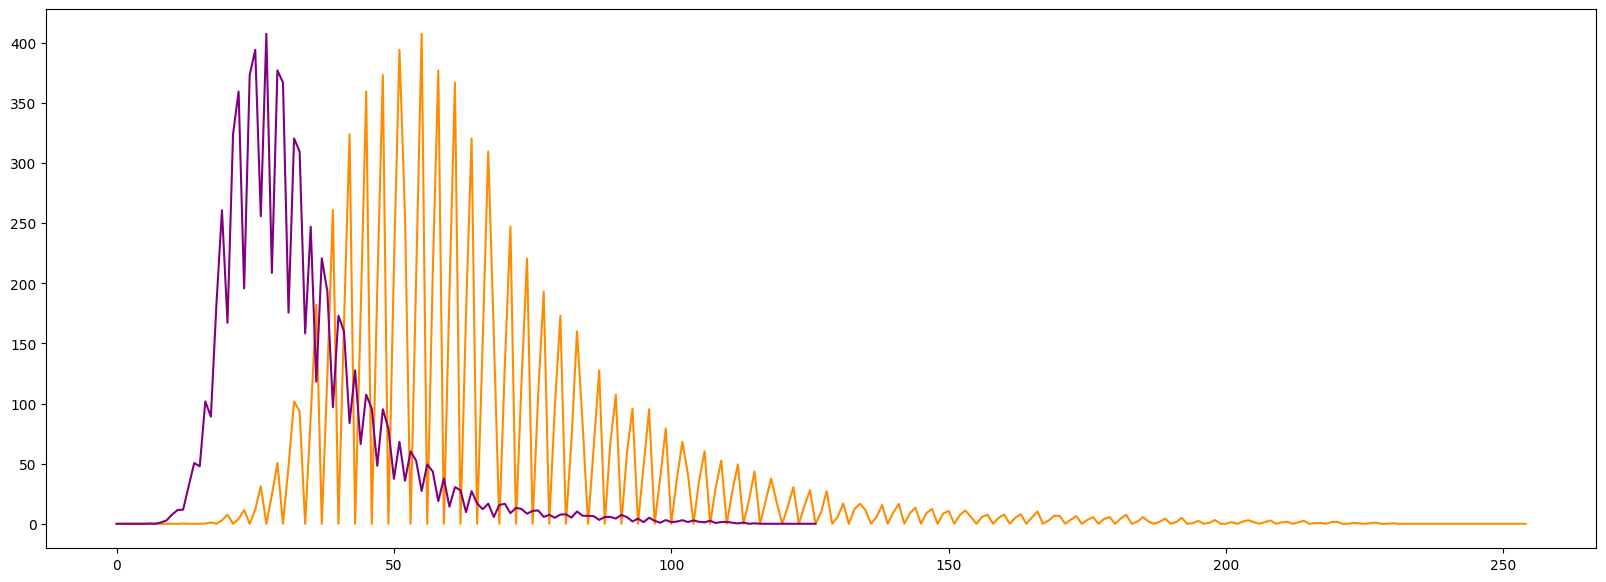

In [ ]:
#Define a new truncated model to only include the conv layers of interest
conv_layer_index = [0,1, 2, 3, 4, 5, 6, 7]
outputs = [tf.model.layers[i].output for i in conv_layer_index]
show_output = Model(inputs=tf.model.inputs, outputs=outputs)

i = 0   # 0.4

print("input histogram")
plt.plot(x_histo[i])
# plt.show()
img = np.array(x_histo[i])
img = np.expand_dims(img, axis=0)
feature_output = show_output.predict(img)

ft = np.array(feature_output[0])
plt.plot(ft[0,:,1],color='darkorange') # second filter
plt.show()

ft = np.array(feature_output[0])
plt.plot(ft[0,:,1], color='darkorange') # second filter
# plt.show()
ft = np.array(feature_output[1])
plt.plot(ft[0,:,1,], color='purple') # second filter
plt.show()

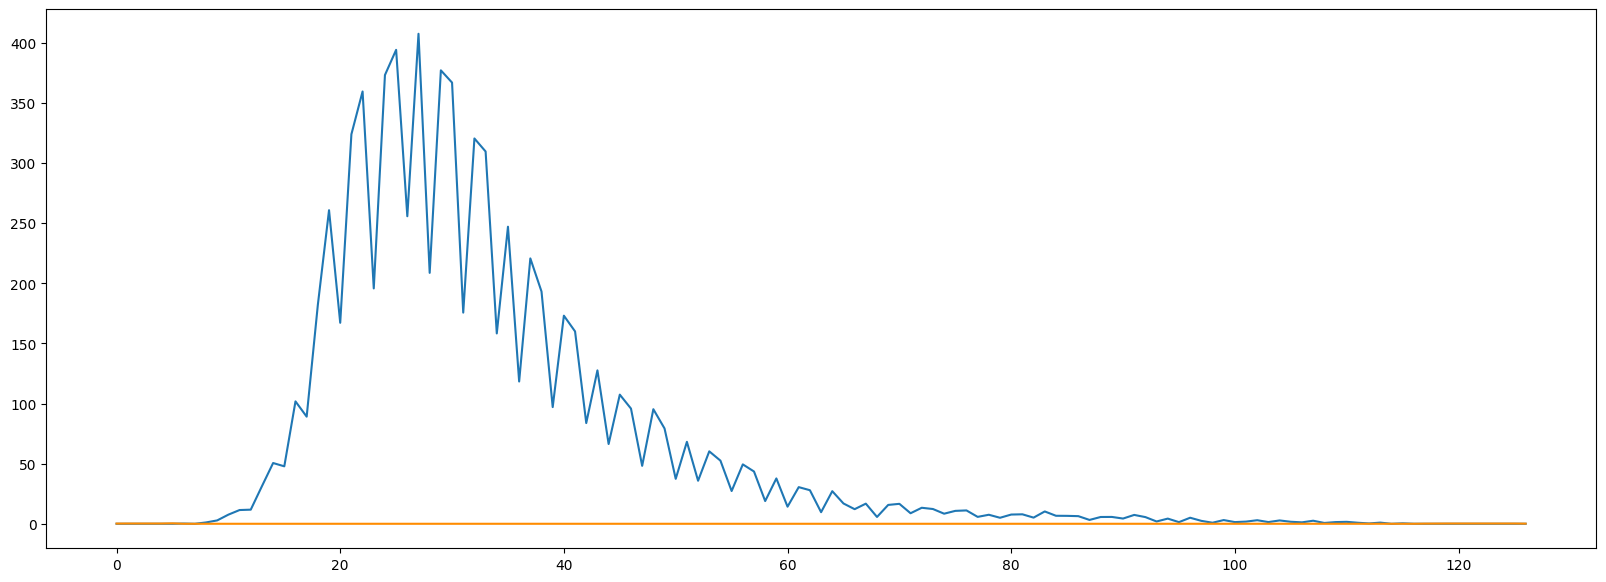

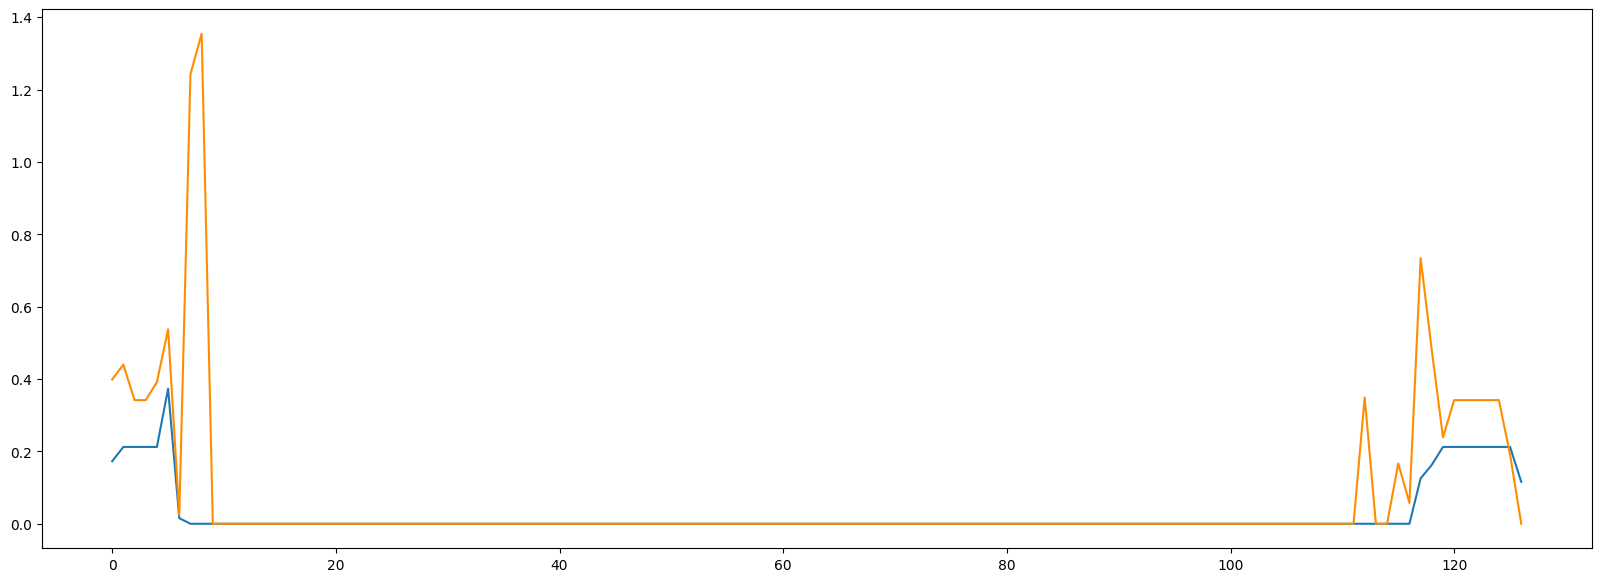

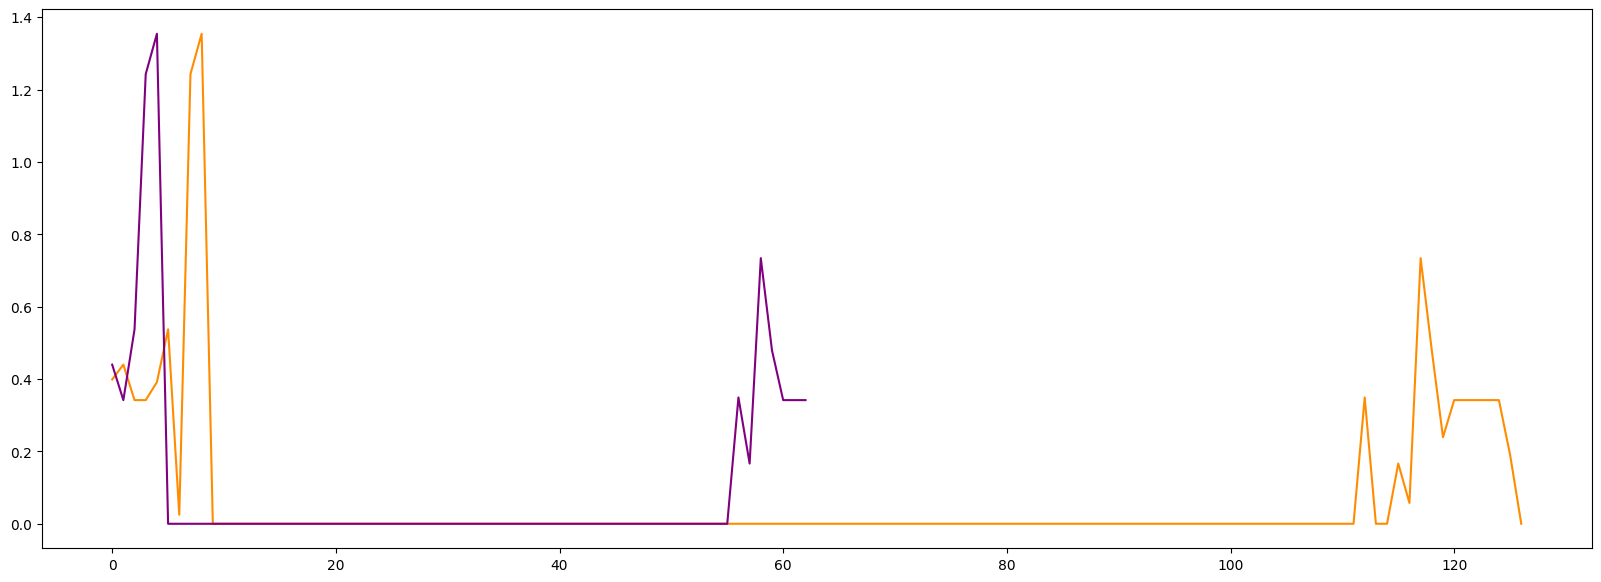

In [ ]:
ft = np.array(feature_output[1])
plt.plot(ft[0,:,1]) # second filter
# plt.show()
ft = np.array(feature_output[2])
plt.plot(ft[0,:,1],color='darkorange') # second filter
plt.show()

ft = np.array(feature_output[2])
plt.plot(ft[0,:,1]) # second filter
# plt.show()
ft = np.array(feature_output[3])
plt.plot(ft[0,:,1], color='darkorange') # second filter
plt.show()

ft = np.array(feature_output[3])
plt.plot(ft[0,:,1], color='darkorange') # second filter
# plt.show()
ft = np.array(feature_output[4])
plt.plot(ft[0,:,1,], color='purple') # second filter
plt.show()

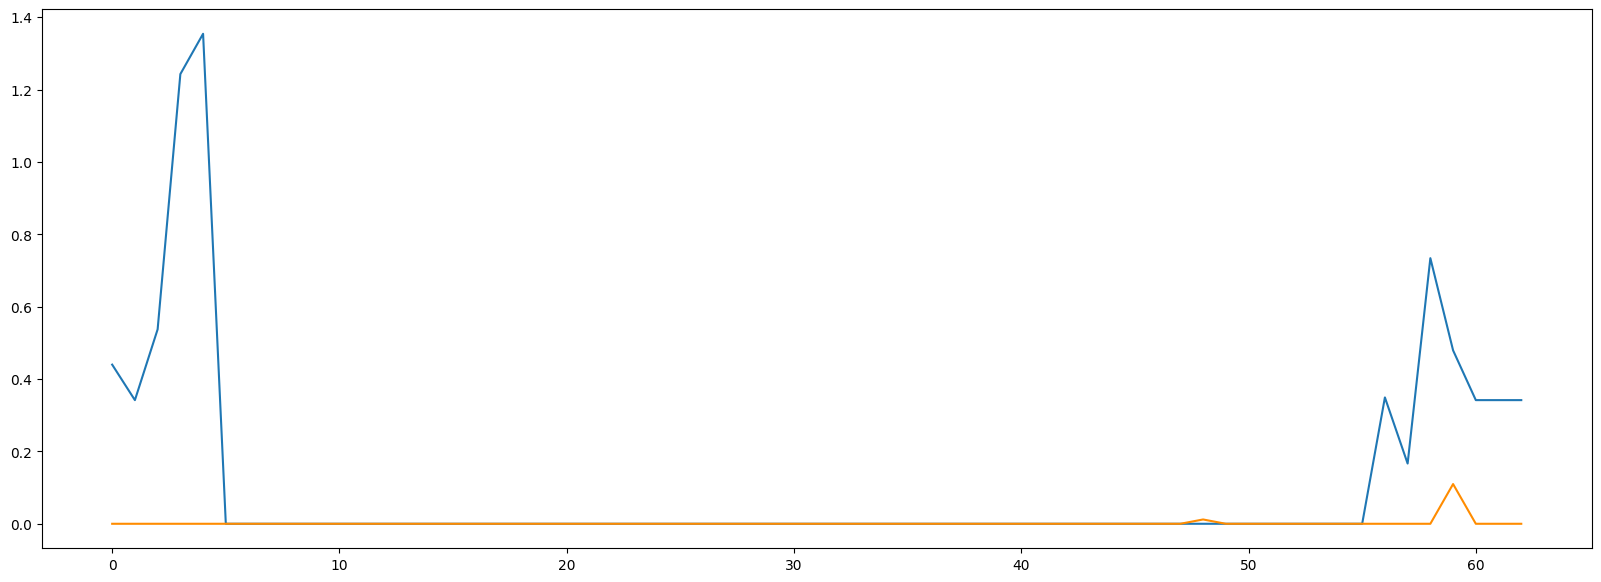

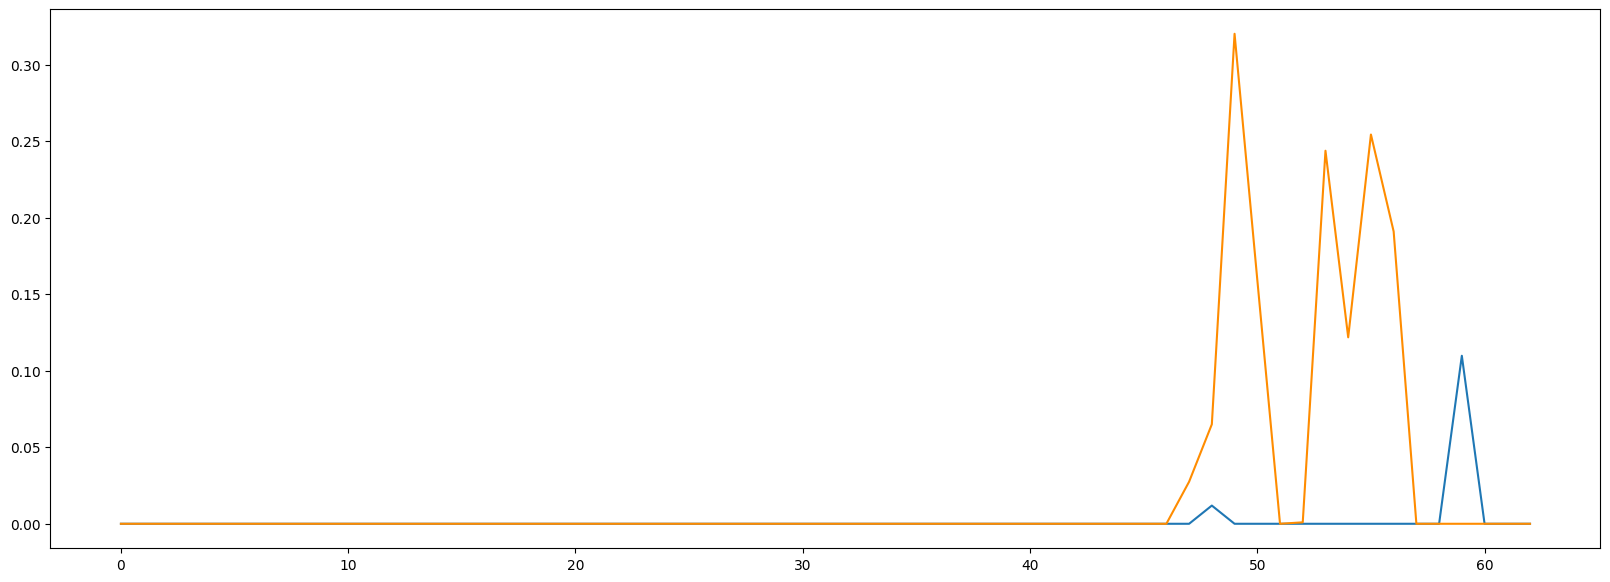

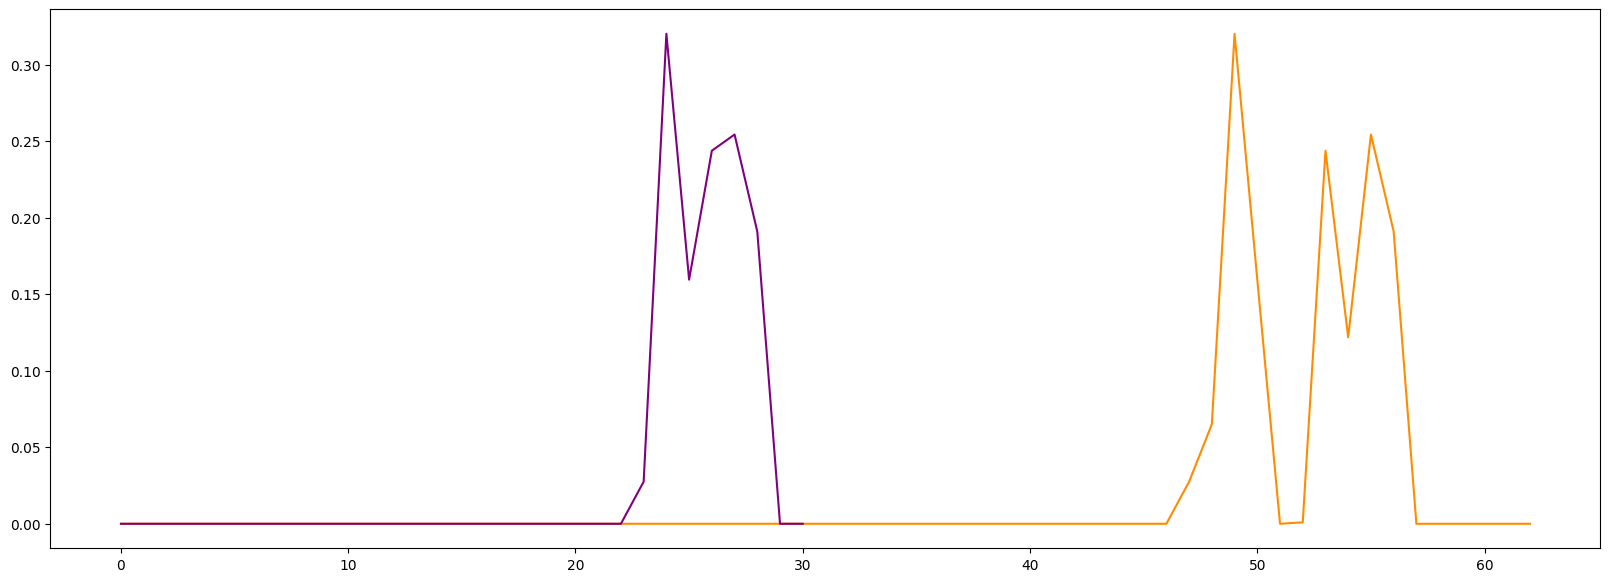

In [ ]:
ft = np.array(feature_output[4])
plt.plot(ft[0,:,1]) # second filter
# plt.show()
ft = np.array(feature_output[5])
plt.plot(ft[0,:,1],color='darkorange') # second filter
plt.show()

ft = np.array(feature_output[5])
plt.plot(ft[0,:,1]) # second filter
# plt.show()
ft = np.array(feature_output[6])
plt.plot(ft[0,:,1], color='darkorange') # second filter
plt.show()

ft = np.array(feature_output[6])
plt.plot(ft[0,:,1], color='darkorange') # second filter
# plt.show()
ft = np.array(feature_output[7])
plt.plot(ft[0,:,1,], color='purple') # second filter
plt.show()

Last index

In [ ]:
i = 0   # 0.4

img = np.array(x_histo[i])
img = np.expand_dims(img, axis=0)
feature_output = tf.model.predict(img)

ft = np.array(feature_output[0])
ft

1/1 [==============================] - 0s 24ms/step


array([5.0446518e-29, 8.0276157e-19, 2.7944337e-12, 1.0000000e+00],
      dtype=float32)

#### Predict

In [ ]:
# Predict Test Set
Prediction = []

for pred in tf.model.predict(x_histo_test):
    for i in range(len(pred)):
        pred_list = list(pred)
        tmp = max(pred)
        label = pred_list.index(tmp)
        Prediction.append(label)

18/18 [==============================] - 0s 2ms/step


In [ ]:
y_True = []

for row in y_test:
    for i in range(len(row)):
        row_list = list(row)
        tmp = max(row)
        label = row_list.index(tmp)
        y_True.append(label)

In [ ]:
# Define CM graph
def show_cm(title,cm):
    mpl.rcParams['font.size']=20
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

    # setting font size
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=12)

    plt.title(f"Confusion Matirx of {title}")
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.xticks([0.5,1.5, 2.5, 3.5], ['0.05%','0.1%', '0.2%', '0.4%'])
    plt.yticks([0.5,1.5, 2.5, 3.5], ['0.05%','0.1%', '0.2%', '0.4%'])
    plt.show()

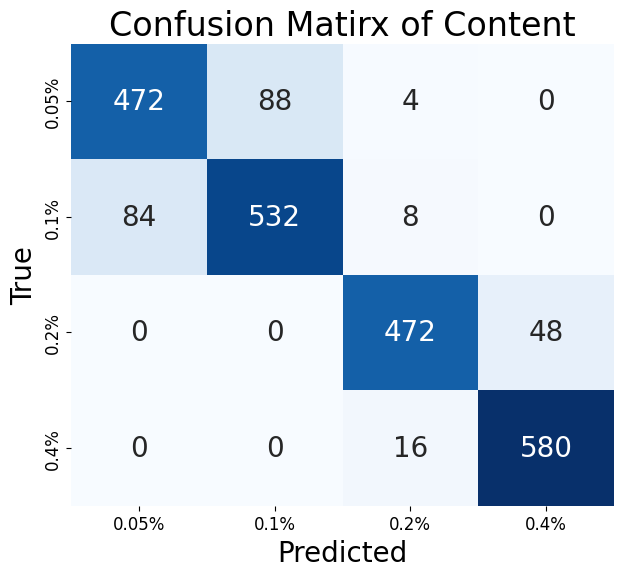

Accuracy: 89.2%


In [ ]:
cm = confusion_matrix(y_True, Prediction)
show_cm('Content', cm)  # 대각선이 올바르게 예측한 경우

print(f'Accuracy: {accuracy_score(y_True,Prediction)*100:0.1f}%')

In [ ]:
# Accuracy
Train_Accuracy = tf.model.evaluate(x_histo, y_train)
Test_Accuracy = tf.model.evaluate(x_histo_test, y_test)

18/18 [==============================] - 0s 3ms/step - loss: 0.3463 - accuracy: 0.8924


## Muti-label Model

In [ ]:
CURRENT = './'
CONTENTS = ['0.05', '0.1', '0.2', '0.4']  # CNT Powder Content
CATEGORIES = ['No', 'Sonic']

In [ ]:
CNT_IMG = []
arr = []

for content in CONTENTS:
  for category in CATEGORIES:
    Path = CURRENT + content + '-' + category
    # print(Path)
    for i, file in enumerate(os.listdir(Path)):
      if file == '.ipynb_checkpoints' or i > 40:
        continue

      # Change Image to Numpy array in grayscale
      img_array = cv2.imread(os.path.join(Path, file), cv2.IMREAD_GRAYSCALE)
      # 이미지 파일에, " CNT powder content, sonication 여부" 추가
      CNT_IMG.append([img_array, CONTENTS.index(content), CATEGORIES.index(category), file])
      print(file)

0.05-No-0028.jpg
0.05-No-0034.jpg
0.05-No-0016.jpg
0.05-No-0038.jpg
0.05-No-0001.jpg
0.05-No-0039.jpg
0.05-No-0013.jpg
0.05-No-0003.jpg
0.05-No-0035.jpg
0.05-No-0040.jpg
0.05-No-0023.jpg
0.05-No-0033.jpg
0.05-No-0018.jpg
0.05-No-0032.jpg
0.05-No-0010.jpg
0.05-No-0014.jpg
0.05-No-0009.jpg
0.05-No-0008.jpg
0.05-No-0037.jpg
0.05-No-0019.jpg
0.05-No-0017.jpg
0.05-No-0027.jpg
0.05-No-0006.jpg
0.05-No-0022.jpg
0.05-No-0012.jpg
0.05-No-0024.jpg
0.05-No-0002.jpg
0.05-No-0031.jpg
0.05-No-0011.jpg
0.05-No-0021.jpg
0.05-No-0029.jpg
0.05-No-0026.jpg
0.05-No-0025.jpg
0.05-No-0007.jpg
0.05-No-0005.jpg
0.05-No-0004.jpg
0.05-No-0015.jpg
0.05-No-0036.jpg
0.05-No-0030.jpg
0.05-No-0020.jpg
0.05-Sonic-0031.jpg
0.05-Sonic-0003.jpg
0.05-Sonic-0013.jpg
0.05-Sonic-0032.jpg
0.05-Sonic-0039.jpg
0.05-Sonic-0014.jpg
0.05-Sonic-0025.jpg
0.05-Sonic-0005.jpg
0.05-Sonic-0007.jpg
0.05-Sonic-0026.jpg
0.05-Sonic-0006.jpg
0.05-Sonic-0017.jpg
0.05-Sonic-0009.jpg
0.05-Sonic-0008.jpg
0.05-Sonic-0020.jpg
0.05-Sonic-0036.jpg


In [ ]:
len(CNT_IMG)

320

In [ ]:
# Four splits in row and six splits in column -> 24 small samples from one 1080 x 1920 image
n_row = 4
n_col = 6

# Resize image to 256 x 256 pixels
img_size = 256

SMALL_IMG = []

for img_array, content, sonication, name in CNT_IMG:
    for i in range(n_row):
        for k in range(n_col):
            height = int(img_array.shape[0]/n_row)
            width = int(img_array.shape[1]/n_col)

            small_img = img_array[i*height:(i+1)*height, k*width:(k+1)*width] # Split -> 270 x 320

            small_img = cv2.resize(small_img, (img_size, img_size)) # Resize -> 256 x 256

            # Normalization
            # small_img = small_img

            SMALL_IMG.append([small_img, content, sonication, name])

In [ ]:
len(SMALL_IMG)

7680

In [ ]:
# Shuffle images to be trained well
random.shuffle(SMALL_IMG)
trainN = int(len(SMALL_IMG) * 0.85)
print(len(SMALL_IMG), trainN)

Train_Data = SMALL_IMG[:trainN]
Test_Data = SMALL_IMG[trainN:]

7680 6528


In [ ]:
x_train = []
y_train = []

for img_array, content, sonication, name in Train_Data:
    x_train.append(img_array)
    y_train.append((content, sonication))

# Change List to Numpy
x_train = np.array(x_train).reshape(trainN, img_size, img_size, 1) # (instances, height, width, depth)
y_train = np.array(y_train)

print(x_train.shape, y_train.shape)

(6528, 256, 256, 1) (6528, 2)


In [ ]:
x_test = []
y_test = []

for img_array, content, sonication, name in Test_Data:
    x_test.append(img_array)
    y_test.append((content, sonication))

x_test = np.array(x_test).reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

print(x_test.shape, y_test.shape)

(1152, 256, 256, 1) (1152, 2)


In [ ]:
y_test

array([[3, 1],
       [3, 1],
       [1, 1],
       ...,
       [3, 0],
       [3, 0],
       [1, 1]])

In [ ]:
# label dataset one-hot coding (multi-label)
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train)
y_test = mlb.transform(y_test)
print(y_test.shape)

(1152, 4)


In [ ]:
import pandas as pd
y_train = pd.DataFrame(y_train, columns=['content', 'sonication'])
y_train

,content,sonication
0,0,1
1,2,0
2,3,0
3,1,1
4,3,0
...,...,...
6523,0,0
6524,2,0
6525,3,1
6526,1,1


In [ ]:
from sklearn.preprocessing import LabelBinarizer
# Content labels
content_lb = LabelBinarizer()
content_labels = content_lb.fit_transform(y_train['content'])
# Whether or not Sonication
sonication_lb = LabelBinarizer()
sonication_labels = sonication_lb.fit_transform(y_train['sonication'])
y_train = np.hstack([content_labels, sonication_labels])
print(y_train.shape)

(6528, 5)


In [ ]:
y_test = pd.DataFrame(y_test, columns=['content', 'sonication'])
content_test_labels = content_lb.transform(y_test['content'])
sonication_test_labels = sonication_lb.transform(y_test['sonication'])
y_test = np.hstack([content_test_labels, sonication_test_labels])

In [ ]:
# 0~255 normalization
x_train_norm = (x_train - np.min(x_train))/(np.max(x_train)-np.min(x_train))*255
x_histo = np.array( [np.histogram(tmp, range(0,256))[0] for tmp in x_train_norm])
x_histo = np.expand_dims(x_histo, axis=2)

In [ ]:
# 0~255 normalization
x_test_norm = (x_test - np.min(x_test))/(np.max(x_test)-np.min(x_test))*255
x_histo_test = np.array( [np.histogram(tmp, range(0,256))[0] for tmp in x_test_norm])
x_histo_test = np.expand_dims(x_histo_test, axis=2)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
with tf.device('/device:GPU:0'):
  tf.model = tf.keras.Sequential()

  tf.model.add(tf.keras.layers.Conv1D(filters=32, input_shape=(255,1), kernel_size=3,
                                    kernel_initializer='he_normal',activation='relu', padding='same'))
  tf.model.add(tf.keras.layers.Dropout(0.2))
  tf.model.add(tf.keras.layers.MaxPooling1D(pool_size=2)) # pool_size = (filter_size, stride)

  tf.model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, kernel_initializer='he_normal',
                                    activation='relu', padding='same'))
  tf.model.add(tf.keras.layers.Dropout(0.2))
  tf.model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, kernel_initializer='he_normal',
                                    activation='relu', padding='same'))
  tf.model.add(tf.keras.layers.Dropout(0.2))
  tf.model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

  tf.model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, kernel_initializer='he_normal',
                                    activation='relu', padding='same'))
  tf.model.add(tf.keras.layers.Dropout(0.2))
  tf.model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, kernel_initializer='he_normal',
                                    activation='relu', padding='same'))
  tf.model.add(tf.keras.layers.Dropout(0.2))
  tf.model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

  tf.model.add(tf.keras.layers.Flatten()) # 3D data -> 1D data
  tf.model.add(tf.keras.layers.Dense(units=5, kernel_initializer='he_normal', activation='softmax'))

  tf.model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])
  tf.model.summary()

  # Define Early Stopping
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

  # Train
  start = datetime.datetime.now()
  run_results = tf.model.fit(x_histo, y_train, validation_split=0.1, batch_size=32, epochs=200, callbacks=[es])
  end = datetime.datetime.now()
  time = end - start
  print("모델 훈련 시간 :", time)


Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_142 (Conv1D)         (None, 255, 32)           128       
                                                                 
 dropout_122 (Dropout)       (None, 255, 32)           0         
                                                                 
 max_pooling1d_90 (MaxPoolin  (None, 127, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_143 (Conv1D)         (None, 127, 64)           6208      
                                                                 
 dropout_123 (Dropout)       (None, 127, 64)           0         
                                                                 
 conv1d_144 (Conv1D)         (None, 127, 64)           12352     
                                                     

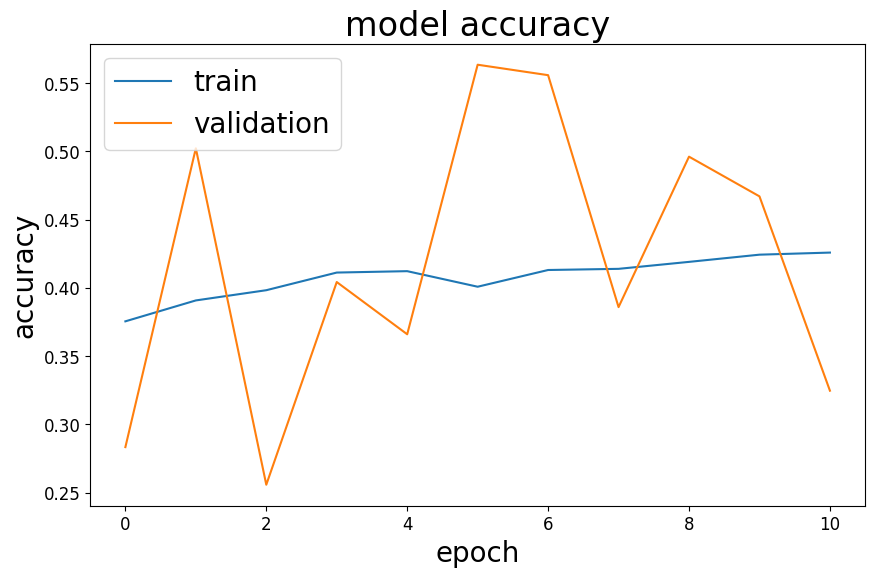

In [ ]:
# summarize history for accuracy
# plt.plot(figuresize())
plt.figure(figsize=(10, 6))
plt.plot(run_results.history['accuracy'])
plt.plot(run_results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:

with tf.device('/device:GPU:0'):
  tf.model = tf.keras.Sequential()

  tf.model.add(tf.keras.layers.Conv1D(filters=32, input_shape=(255,1), kernel_size=3,
                                    kernel_initializer='he_normal',activation='relu', padding='same'))
  tf.model.add(tf.keras.layers.Dropout(0.2))
  tf.model.add(tf.keras.layers.MaxPooling1D(pool_size=2)) # pool_size = (filter_size, stride)

  tf.model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, kernel_initializer='he_normal',
                                    activation='relu', padding='same'))
  tf.model.add(tf.keras.layers.Dropout(0.2))
  tf.model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, kernel_initializer='he_normal',
                                    activation='relu', padding='same'))
  tf.model.add(tf.keras.layers.Dropout(0.2))
  tf.model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

  tf.model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, kernel_initializer='he_normal',
                                    activation='relu', padding='same'))
  tf.model.add(tf.keras.layers.Dropout(0.2))
  tf.model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, kernel_initializer='he_normal',
                                    activation='relu', padding='same'))
  tf.model.add(tf.keras.layers.Dropout(0.2))
  tf.model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

  tf.model.add(tf.keras.layers.Flatten()) # 3D data -> 1D data
  tf.model.add(tf.keras.layers.Dense(units=5, kernel_initializer='he_normal', activation='softmax'))

  tf.model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])
  tf.model.summary()

  # Train
  start = datetime.datetime.now()
  run_results = tf.model.fit(x_histo, y_train, validation_split=0.1, batch_size=32, epochs=200)
  end = datetime.datetime.now()
  time = end - start
  print("모델 훈련 시간 :", time)


Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_147 (Conv1D)         (None, 255, 32)           128       
                                                                 
 dropout_127 (Dropout)       (None, 255, 32)           0         
                                                                 
 max_pooling1d_93 (MaxPoolin  (None, 127, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_148 (Conv1D)         (None, 127, 64)           6208      
                                                                 
 dropout_128 (Dropout)       (None, 127, 64)           0         
                                                                 
 conv1d_149 (Conv1D)         (None, 127, 64)           12352     
                                                     

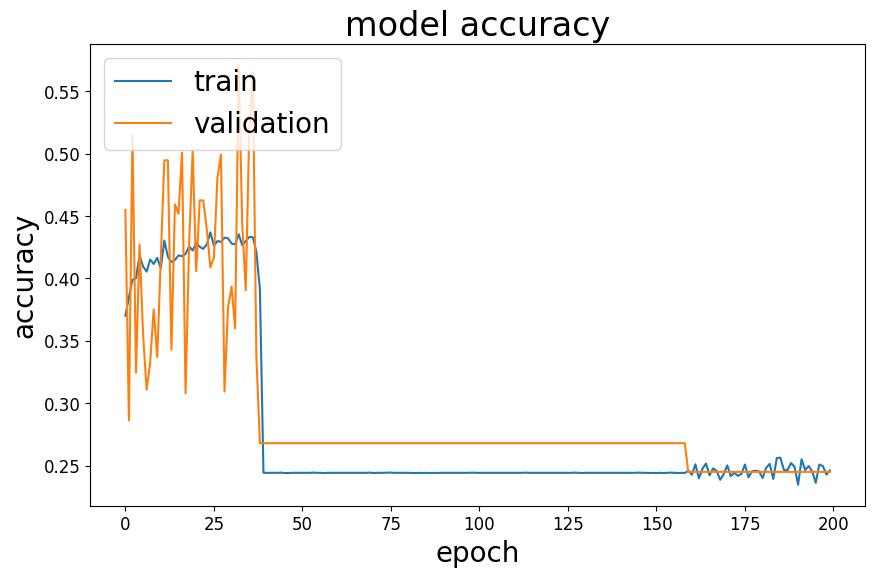

In [ ]:
# summarize history for accuracy
# plt.plot(figuresize())
plt.figure(figsize=(10, 6))
plt.plot(run_results.history['accuracy'])
plt.plot(run_results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Accuracy
Train_Accuracy = tf.model.evaluate(x_histo, y_train)
Test_Accuracy = tf.model.evaluate(x_histo_test, y_test)

36/36 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.2448


#### Predict

In [ ]:
tf.model.predict(x_histo_test)

36/36 [==============================] - 0s 2ms/step


array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [ ]:
# Predict Test Set
Prediction = []

for pred in tf.model.predict(x_histo_test):
    for i in range(len(pred)):
        tup = []
        pred_list = list(pred)
        content_list = pred_list[:-1]
        tmp = max(content_list)
        content = content_list.index(tmp)
        tup.append(content)
        if pred_list[-1] >= 0.5:
          tup.append('Sonication')
        else:
          tup.append("No Sonication")
        Prediction.append(tup)


36/36 [==============================] - 0s 2ms/step


In [ ]:
y_True = []

for row in y_test:
    for i in range(len(row)):
        tup = []
        pred_list = list(row)
        content_list = pred_list[:-1]
        tmp = max(content_list)
        content = content_list.index(tmp)
        tup.append(content)
        if pred_list[-1] >= 0.5:
          tup.append('Sonication')
        else:
          tup.append("No Sonication")
        y_True.append(tup)

In [ ]:
def show_cm(title,cm):
    mpl.rcParams['font.size']=20
    plt.figure(figsize=(8,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

    # setting font size
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=12)

    plt.title(f"Confusion Matirx of {title}")
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.xticks([0.5,1.5, 2.5, 3.5], ['0.05%','0.1%', '0.2%', '0.4%'])
    plt.yticks([0.5,1.5, 2.5, 3.5], ['0.05%','0.1%', '0.2%', '0.4%'])
    plt.show()


In [ ]:
y_True = pd.DataFrame(y_True, columns=['content', 'soni'])
Prediction = pd.DataFrame(Prediction, columns=['content', 'soni'])

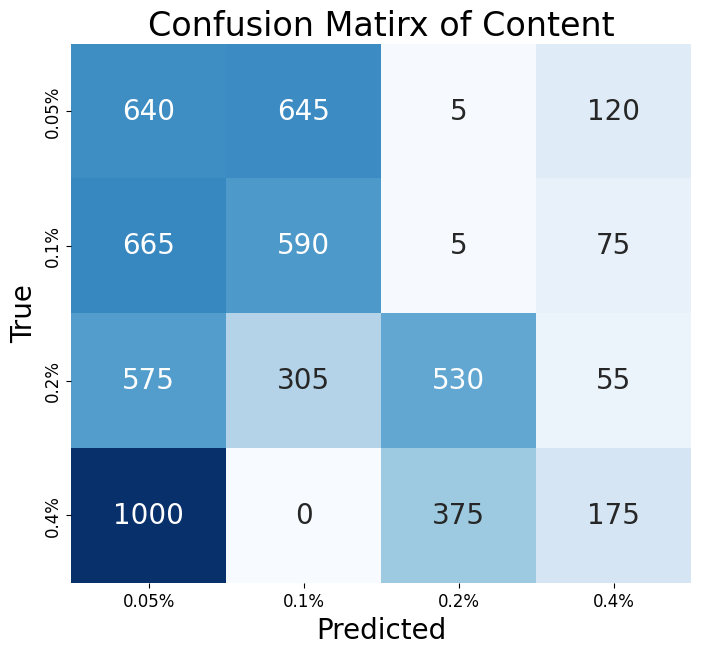

Accuracy: 33.6%


In [ ]:
cm = confusion_matrix(y_True['content'], Prediction['content'])
show_cm('Content', cm)  # 대각선이 올바르게 예측한 경우

print(f"Accuracy: {accuracy_score(y_True['content'], Prediction['content']) * 100:0.1f}%")

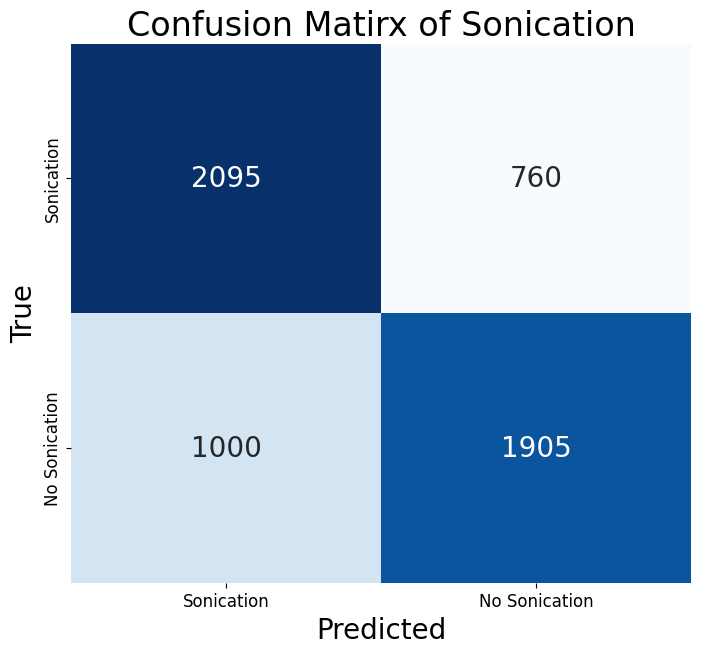

Accuracy: 69.4%


In [ ]:
def show_cm(title,cm):
    mpl.rcParams['font.size']=20
    plt.figure(figsize=(8,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

    # setting font size
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=12)

    plt.title(f"Confusion Matirx of {title}")
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.xticks([0.5,1.5], ['Sonication', 'No Sonication'])
    plt.yticks([0.5,1.5], ['Sonication', 'No Sonication'])
    plt.show()

cm = confusion_matrix(y_True['soni'], Prediction['soni'])
show_cm('Sonication', cm)  # 대각선이 올바르게 예측한 경우

print(f"Accuracy: {accuracy_score(y_True['soni'], Prediction['soni']) * 100:0.1f}%")

In [ ]:
# Accuracy
Train_Accuracy = tf.model.evaluate(x_histo, y_train)
Test_Accuracy = tf.model.evaluate(x_histo_test, y_test)

36/36 [==============================] - 0s 3ms/step - loss: 16427543552.0000 - accuracy: 0.2587
